This time for real, I swear. metaABaCo is a framework for ensuring good clustering representations implementing Mixture-of-Aggregated-Posteriors as prior distribution.

## Libraries

In [1]:
# Essentials
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, ListedColormap
from matplotlib.patches import Ellipse
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from skbio.stats.ordination import pcoa
from skbio.stats.distance import DistanceMatrix, permanova
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
import scipy.stats as stats
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu, kruskal, nbinom, multivariate_normal
from statsmodels.stats.multitest import multipletests
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import os
import re
import random
import statsmodels.api as sm
import seaborn as sns
import networkx as nx
# User libraries
from abaco.BatchEffectDataLoader import DataPreprocess, DataTransform, one_hot_encoding
from abaco.BatchEffectCorrection import correctCombat, correctLimma_rBE, correctBMC, correctPLSDAbatch_R, correctCombatSeq, correctConQuR
from abaco.BatchEffectPlots import plotPCA, plotPCoA, plot_LISI_perplexity
from abaco.BatchEffectMetrics import all_metrics, pairwise_distance, pairwise_distance_std, PERMANOVA, pairwise_distance_multi_run, kBET, ARI, ASW, iLISI_norm
from src.ABaCo.metaABaCo import metaABaCo

>> clustergrammer2 backend version 0.18.0


## Anaerobic Digestion dataset

### Dataloading

In [2]:
# Load AD count
path = "data/dataset_ad.csv"
ad_count_batch_label = "batch"
ad_count_sample_label = "sample"
ad_count_bio_label = "trt"

ad_count_data = DataPreprocess(
    path,
    factors=[ad_count_sample_label, ad_count_batch_label, ad_count_bio_label]
)

ad_count_batch_size = 5
ad_count_bio_size = 2
ad_count_input_size = ad_count_data.select_dtypes(include="number").shape[1]

### Model setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = metaABaCo(ad_count_data, ad_count_bio_size, ad_count_bio_label, ad_count_batch_size, ad_count_batch_label, ad_count_input_size, device, 
                  prior = "VMM", pdist="ZINB", epochs=[1000, 500, 500])

### Model training

In [10]:
model.correct(adv_lr=1e-4, disc_lr=1e-5, w_elbo_nll=1e-2, phase_3_vae_lr=1e-7)

Training: VAE for learning meaningful embeddings: 100%|██████████| 1000/1000 [00:19<00:00, 50.41it/s, bio_penalty=0.0029, clustering_loss=0.0174, elbo=6.7521, epoch=999/1001, vae_loss=6.7724]
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 500/500 [00:11<00:00, 44.90it/s, adv_loss=-1.5899, bio_penalty=0.0014, clustering_loss=0.0000, disc_loss=1.5899, elbo=6.7861, epoch=499/501, vae_loss=6.7875]
Training: VAE decoder with masked batch labels: 100%|██████████| 500/500 [00:04<00:00, 103.72it/s, cycle_loss=0.0000, epoch=500/500, vae_loss=10.8344]


### Reconstructing the data

In [11]:
recon_data = model.reconstruct()

plotPCoA(recon_data, sample_label=ad_count_sample_label, batch_label=ad_count_batch_label, experiment_label=ad_count_bio_label)

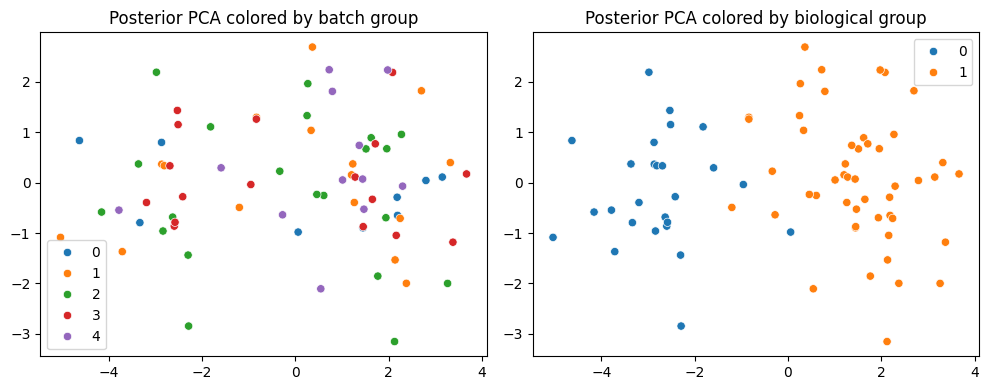

In [12]:
model.plot_pca_posterior(figsize=(10,4))

### Multi-run test

In [4]:
iter = 5
recons = []

for i in range(iter):
    print(f"Iteration {i+1} / {iter}:")
    model = metaABaCo(ad_count_data, ad_count_bio_size, ad_count_bio_label, ad_count_batch_size, ad_count_batch_label, ad_count_input_size, device, 
                  prior = "VMM", pdist="ZIDM", epochs=[5000, 2000, 1000])
    model.correct(adv_lr=1e-5, disc_lr=1e-5, w_elbo_nll=1e-2, phase_2_vae_lr = 1e-5, phase_3_vae_lr=1e-6)
    recon_data = model.reconstruct()
    recons.append(recon_data)

Iteration 1 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 5000/5000 [01:15<00:00, 66.11it/s, bio_penalty=0.0004, clustering_loss=0.0127, elbo=310.1620, epoch=4999/5001, vae_loss=310.1751]
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 2000/2000 [00:31<00:00, 63.23it/s, adv_loss=-1.5703, bio_penalty=0.0032, clustering_loss=0.0000, disc_loss=1.5703, elbo=334.6260, epoch=1999/2001, vae_loss=334.6292]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:07<00:00, 131.30it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=1022.1716]


Iteration 2 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 5000/5000 [01:14<00:00, 67.22it/s, bio_penalty=0.0004, clustering_loss=0.0157, elbo=310.9819, epoch=4999/5001, vae_loss=310.9980]
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 2000/2000 [00:37<00:00, 53.23it/s, adv_loss=-1.5759, bio_penalty=0.0027, clustering_loss=0.0000, disc_loss=1.5759, elbo=358.1740, epoch=1999/2001, vae_loss=358.1767]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:08<00:00, 122.18it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=1042.1359]


Iteration 3 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 5000/5000 [01:16<00:00, 65.41it/s, bio_penalty=0.0003, clustering_loss=0.0036, elbo=310.8278, epoch=4999/5001, vae_loss=310.8316]
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 2000/2000 [00:36<00:00, 54.38it/s, adv_loss=-1.5343, bio_penalty=0.0020, clustering_loss=0.0000, disc_loss=1.5343, elbo=336.9183, epoch=1999/2001, vae_loss=336.9203]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:08<00:00, 121.99it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=1094.3560]


Iteration 4 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 5000/5000 [01:20<00:00, 62.43it/s, bio_penalty=0.0078, clustering_loss=0.0143, elbo=312.7289, epoch=4999/5001, vae_loss=312.7510]
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 2000/2000 [00:35<00:00, 56.04it/s, adv_loss=-1.5614, bio_penalty=0.1138, clustering_loss=0.0000, disc_loss=1.5614, elbo=330.6765, epoch=1999/2001, vae_loss=330.7904]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:07<00:00, 126.12it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=1315.8247]


Iteration 5 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 5000/5000 [01:15<00:00, 66.25it/s, bio_penalty=0.0002, clustering_loss=0.0035, elbo=306.8797, epoch=4999/5001, vae_loss=306.8834]
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 2000/2000 [00:35<00:00, 57.11it/s, adv_loss=-1.5469, bio_penalty=0.0031, clustering_loss=0.0000, disc_loss=1.5469, elbo=323.0490, epoch=1999/2001, vae_loss=323.0521]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:07<00:00, 125.76it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=1117.9163]


### K-W test: significant taxa from different groups

In [12]:
# Define function to compute Kruskal-Wallis per taxa
def kruskal_wallis_taxa(df, sample_label, batch_label, bio_label, method):
    # Melt dataframe
    melt_df = pd.melt(df, id_vars = [sample_label, batch_label, bio_label], var_name = "taxa", value_name = "norm_counts")
    # Comput K-W test
    results = []
    # Per taxa
    for taxon, df_taxa in melt_df.groupby("taxa"):
        # For each biological group
        groups = []

        for grp, df_grp in df_taxa.groupby(bio_label):

            groups.append(df_grp["norm_counts"].values)

        try:
            stat, pval = kruskal(*groups)
            
        except ValueError:
            continue

        results.append({"taxa":taxon,
                        "H_stat":stat,
                        "p-value":pval})

    kw_df = pd.DataFrame(results)

    rej, p_adj, _, _ = multipletests(kw_df["p-value"], method = "fdr_bh")
    kw_df["p_adj"] = p_adj
    kw_df["significant"] = rej
    kw_df["method"] = method
    return kw_df

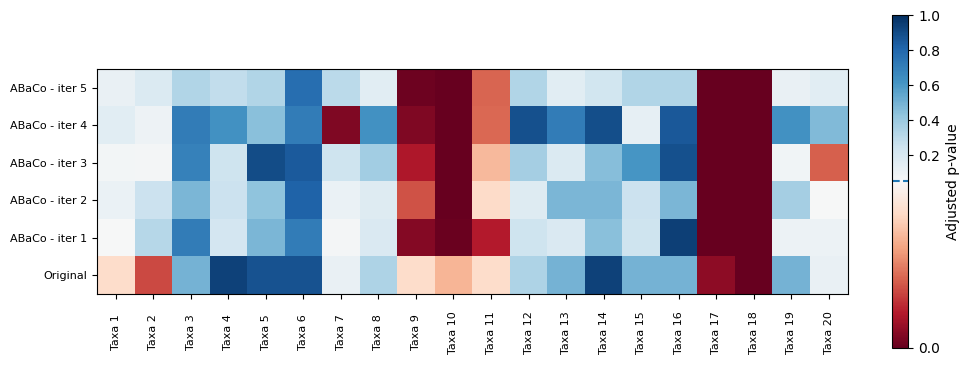

In [13]:
# Define top taxonomic groups on each dataset
ad_data_clr = DataTransform(
    ad_count_data, [ad_count_sample_label, ad_count_batch_label, ad_count_bio_label], count=True
)


ad_top_taxa = (
    ad_data_clr.select_dtypes(include="number")
    .mean(axis=0)
    .sort_values(ascending=False)
    .index[:20]
)

ad_kw_results = pd.DataFrame()

# Original
ad_top_taxa_cols = ad_data_clr.select_dtypes(include="number").columns.intersection(
    ad_top_taxa
)
ad_non_num_cols = ad_data_clr.select_dtypes(exclude="number").columns
ad_top_taxa_data = ad_data_clr[list(ad_non_num_cols) + list(ad_top_taxa_cols)]

ad_kw_results = pd.concat([ad_kw_results, kruskal_wallis_taxa(ad_top_taxa_data, ad_count_sample_label, ad_count_batch_label, ad_count_bio_label, "Original")], axis = 0)

# ABaCo
for i in range(iter):
    recon_data = recons[i]
    recon_data_clr = DataTransform(
        recon_data, [ad_count_sample_label, ad_count_batch_label, ad_count_bio_label], count=True
    )
    ad_top_taxa_abaco_data = recon_data_clr[list(ad_non_num_cols) + list(ad_top_taxa_cols)]

    ad_kw_results = pd.concat([ad_kw_results, kruskal_wallis_taxa(ad_top_taxa_abaco_data, ad_count_sample_label, ad_count_batch_label, ad_count_bio_label, f"ABaCo - iter {i+1}")], axis = 0)

# Plot heatmap
heat_df = ad_kw_results.pivot(index="method", columns="taxa", values="p_adj").reindex(index=ad_kw_results["method"].drop_duplicates().tolist())

vmin = 0
vmax = 1
mid = 0.05

norm = TwoSlopeNorm(vmin=vmin, vcenter=mid, vmax=vmax)
cmap = plt.get_cmap("RdBu")

n_rows, n_cols = heat_df.shape
x = np.arange(n_cols + 1)
y = np.arange(n_rows + 1)

cell_size = 0.3
fig_width = n_cols * cell_size
fig_height = n_rows * cell_size

fig, ax = plt.subplots(figsize=(fig_width + 4, fig_height + 2))

im = ax.pcolormesh(
    x, y, heat_df.values,
    norm=norm,
    cmap=cmap,
    shading="flat"
)

generic_labels = [f"Taxa {i+1}" for i in range(n_cols)]
ax.set_xticks(np.arange(n_cols) + 0.5)
ax.set_xticklabels(generic_labels, rotation=90, va='center', fontsize=8)

ax.set_yticks(np.arange(n_rows) + 0.5)
ax.set_yticklabels(heat_df.index, fontsize=8)
ax.set_aspect('equal')
ax.tick_params(axis='x', which='major', pad=24)

cbar = fig.colorbar(im, ax=ax, fraction=0.1)
cbar.set_label('Adjusted p-value')
cbar.ax.hlines(mid, *cbar.ax.get_xlim(), linestyles='--')

plt.tight_layout()
plt.show()


## Inflammatory Bowel Disease dataset

### Dataloading

In [14]:
# Load AD count
path = "data/MGnify/IBD/IBD_dataset_genus.csv"
ibd_batch_label = "project ID"
ibd_sample_label = "run ID"
ibd_bio_label = "associated phenotype"

ibd_data = DataPreprocess(
    path,
    factors=[ibd_sample_label, ibd_batch_label, ibd_bio_label]
)

ibd_batch_size = 2
ibd_bio_size = 3
ibd_input_size = ibd_data.select_dtypes(include="number").shape[1]

### Model setup

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = metaABaCo(
    ibd_data,
    ibd_bio_size,
    ibd_bio_label,
    ibd_batch_size,
    ibd_batch_label,
    ibd_input_size,
    device,
    prior="VMM",
    pdist="ZIDM",
    epochs=[3000, 1000, 1000],
)

### Model training

In [19]:
model.correct(disc_lr=1e-7, adv_lr=1e-7, w_bio_penalty=100.0, w_cluster_penalty=1.0, phase_1_vae_lr=1e-4, phase_2_vae_lr=1e-6, w_elbo_nll=1e-2)

Training: VAE for learning meaningful embeddings: 100%|██████████| 3000/3000 [01:24<00:00, 35.50it/s, bio_penalty=2.7163, clustering_loss=0.0310, elbo=1052.0557, epoch=2999/3001, vae_loss=1054.8030] 
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 1000/1000 [00:25<00:00, 39.64it/s, adv_loss=-0.7130, bio_penalty=2.5919, clustering_loss=0.0000, disc_loss=0.7130, elbo=1047.2130, epoch=999/1001, vae_loss=1049.8049]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:13<00:00, 74.75it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=1073.6992]


### Reconstructing the data

In [21]:
recon_data = model.reconstruct(mask=True)

plotPCoA(ibd_data, sample_label=ibd_sample_label, batch_label=ibd_batch_label, experiment_label=ibd_bio_label)

plotPCoA(recon_data, sample_label=ibd_sample_label, batch_label=ibd_batch_label, experiment_label=ibd_bio_label)

### Multi-run test

In [47]:
iter = 5

recons = []

for i in range(iter):
    print(f"Iteration {i+1} / {iter}:")
    model = metaABaCo(
        ibd_data,
        ibd_bio_size,
        ibd_bio_label,
        ibd_batch_size,
        ibd_batch_label,
        ibd_input_size,
        device,
        prior="VMM",
        pdist="ZIDM",
        epochs=[3000, 1000, 1000],
    )
    model.correct(disc_lr=1e-7, adv_lr=1e-7, w_bio_penalty=100.0, w_cluster_penalty=1.0, phase_1_vae_lr=2e-4, phase_2_vae_lr=1e-6, w_elbo_nll=1e-2)
    recon_data = model.reconstruct(mask=True)
    recons.append(recon_data)

Iteration 1 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 3000/3000 [01:09<00:00, 42.88it/s, bio_penalty=1.8691, clustering_loss=0.0586, elbo=981.3354, epoch=2999/3001, vae_loss=983.2632]    
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 1000/1000 [00:24<00:00, 40.45it/s, adv_loss=-0.6840, bio_penalty=1.7290, clustering_loss=0.0000, disc_loss=0.6840, elbo=973.7917, epoch=999/1001, vae_loss=975.5208]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:12<00:00, 80.14it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=1052.3224]


Iteration 2 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 3000/3000 [01:10<00:00, 42.76it/s, bio_penalty=1.1566, clustering_loss=0.0432, elbo=958.5867, epoch=2999/3001, vae_loss=959.7864]  
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 1000/1000 [00:24<00:00, 40.55it/s, adv_loss=-0.7171, bio_penalty=1.1061, clustering_loss=0.0000, disc_loss=0.7171, elbo=950.1127, epoch=999/1001, vae_loss=951.2188]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:12<00:00, 78.44it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=1024.5265]


Iteration 3 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 3000/3000 [01:10<00:00, 42.55it/s, bio_penalty=0.9254, clustering_loss=0.0370, elbo=971.9347, epoch=2999/3001, vae_loss=972.8971]  
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 1000/1000 [00:24<00:00, 40.15it/s, adv_loss=-0.7094, bio_penalty=0.8739, clustering_loss=0.0000, disc_loss=0.7094, elbo=964.1718, epoch=999/1001, vae_loss=965.0458]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:12<00:00, 80.86it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=1038.9081]


Iteration 4 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 3000/3000 [01:06<00:00, 44.94it/s, bio_penalty=1.0730, clustering_loss=0.0263, elbo=976.8561, epoch=2999/3001, vae_loss=977.9554]  
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 1000/1000 [00:23<00:00, 42.21it/s, adv_loss=-0.7237, bio_penalty=1.0445, clustering_loss=0.0000, disc_loss=0.7237, elbo=970.4375, epoch=999/1001, vae_loss=971.4820]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:12<00:00, 82.01it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=1038.9241]


Iteration 5 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 3000/3000 [01:03<00:00, 46.97it/s, bio_penalty=0.7513, clustering_loss=0.0340, elbo=967.4573, epoch=2999/3001, vae_loss=968.2426]   
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 1000/1000 [00:24<00:00, 40.48it/s, adv_loss=-0.6900, bio_penalty=0.7333, clustering_loss=0.0000, disc_loss=0.6900, elbo=957.9532, epoch=999/1001, vae_loss=958.6865]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:12<00:00, 79.79it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=1015.8259]


### K-W test: significantly different taxonomic groups 

In [48]:
# Define function to compute Kruskal-Wallis per taxa
def kruskal_wallis_taxa(df, sample_label, batch_label, bio_label, method):
    # Melt dataframe
    melt_df = pd.melt(df, id_vars = [sample_label, batch_label, bio_label], var_name = "taxa", value_name = "norm_counts")
    # Comput K-W test
    results = []
    # Per taxa
    for taxon, df_taxa in melt_df.groupby("taxa"):
        # For each biological group
        groups = []

        for grp, df_grp in df_taxa.groupby(bio_label):

            groups.append(df_grp["norm_counts"].values)

        try:
            stat, pval = kruskal(*groups)
            
        except ValueError:
            continue

        results.append({"taxa":taxon,
                        "H_stat":stat,
                        "p-value":pval})

    kw_df = pd.DataFrame(results)

    rej, p_adj, _, _ = multipletests(kw_df["p-value"], method = "fdr_bh")
    kw_df["p_adj"] = p_adj
    kw_df["significant"] = rej
    kw_df["method"] = method
    return kw_df

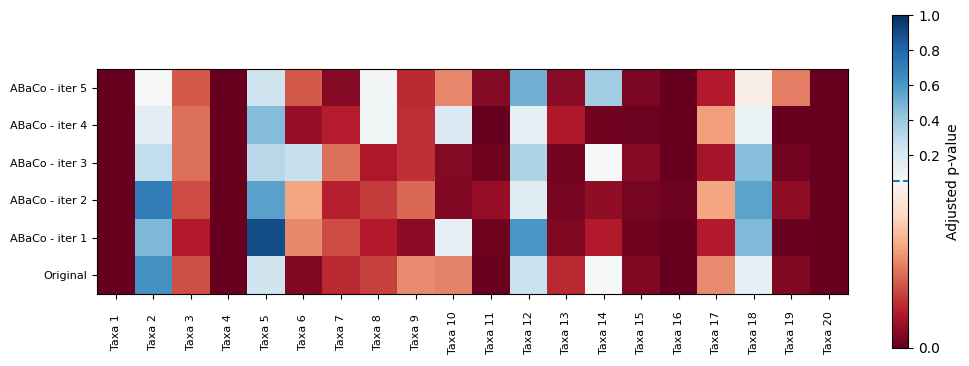

In [49]:
# Define top taxonomic groups on each dataset
ibd_data_clr = DataTransform(
    ibd_data, [ibd_sample_label, ibd_batch_label, ibd_bio_label], count=True
)


ibd_top_taxa = (
    ibd_data_clr.select_dtypes(include="number")
    .mean(axis=0)
    .sort_values(ascending=False)
    .index[:20]
)

ibd_kw_results = pd.DataFrame()

# Original
ibd_top_taxa_cols = ibd_data_clr.select_dtypes(include="number").columns.intersection(
    ibd_top_taxa
)
ibd_non_num_cols = ibd_data_clr.select_dtypes(exclude="number").columns
ibd_top_taxa_data = ibd_data_clr[list(ibd_non_num_cols) + list(ibd_top_taxa_cols)]

ibd_kw_results = pd.concat([ibd_kw_results, kruskal_wallis_taxa(ibd_top_taxa_data, ibd_sample_label, ibd_batch_label, ibd_bio_label, "Original")], axis = 0)

# ABaCo
for i in range(iter):
    recon_data = recons[i]
    recon_data_clr = DataTransform(
        recon_data, [ibd_sample_label, ibd_batch_label, ibd_bio_label], count=True
    )
    ibd_top_taxa_abaco_data = recon_data_clr[list(ibd_non_num_cols) + list(ibd_top_taxa_cols)]

    ibd_kw_results = pd.concat([ibd_kw_results, kruskal_wallis_taxa(ibd_top_taxa_abaco_data, ibd_sample_label, ibd_batch_label, ibd_bio_label, f"ABaCo - iter {i+1}")], axis = 0)

# Plot heatmap
heat_df = ibd_kw_results.pivot(index="method", columns="taxa", values="p_adj").reindex(index=ibd_kw_results["method"].drop_duplicates().tolist())

vmin = 0
vmax = 1
mid = 0.05

norm = TwoSlopeNorm(vmin=vmin, vcenter=mid, vmax=vmax)
cmap = plt.get_cmap("RdBu")

n_rows, n_cols = heat_df.shape
x = np.arange(n_cols + 1)
y = np.arange(n_rows + 1)

cell_size = 0.3
fig_width = n_cols * cell_size
fig_height = n_rows * cell_size

fig, ax = plt.subplots(figsize=(fig_width + 4, fig_height + 2))

im = ax.pcolormesh(
    x, y, heat_df.values,
    norm=norm,
    cmap=cmap,
    shading="flat"
)

generic_labels = [f"Taxa {i+1}" for i in range(n_cols)]
ax.set_xticks(np.arange(n_cols) + 0.5)
ax.set_xticklabels(generic_labels, rotation=90, va='center', fontsize=8)

ax.set_yticks(np.arange(n_rows) + 0.5)
ax.set_yticklabels(heat_df.index, fontsize=8)
ax.set_aspect('equal')
ax.tick_params(axis='x', which='major', pad=24)

cbar = fig.colorbar(im, ax=ax, fraction=0.1)
cbar.set_label('Adjusted p-value')
cbar.ax.hlines(mid, *cbar.ax.get_xlim(), linestyles='--')

plt.tight_layout()
plt.show()


## DTU-GE dataset

### Dataloading

In [25]:
# Load DTU-GE count
path = "data/MGnify/DTU-GE/count/DTU-GE_phylum_count_data_filtered.csv"
dtu_batch_label = "pipeline"
dtu_sample_label = "accession"
dtu_bio_label = "location"

dtu_data = DataPreprocess(
    path,
    factors=[dtu_sample_label, dtu_batch_label, dtu_bio_label]
)

dtu_batch_size = 2
dtu_bio_size = 4
dtu_input_size = dtu_data.select_dtypes(include="number").shape[1]

### Model setup

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = metaABaCo(
    dtu_data,
    dtu_bio_size,
    dtu_bio_label,
    dtu_batch_size,
    dtu_batch_label,
    dtu_input_size,
    device,
    prior="VMM",
    pdist="ZIDM",
    epochs=[3000, 1000, 1000],
)

### Model training

In [ ]:
model.correct(adv_lr=1e-6, disc_lr=1e-6, w_bio_penalty=100.0, phase_1_vae_lr=2e-4, phase_2_vae_lr=1e-6, phase_3_vae_lr=1e-7, w_elbo_nll=1e-2)

Training: VAE for learning meaningful embeddings: 100%|██████████| 3000/3000 [01:13<00:00, 40.55it/s, bio_penalty=0.9827, clustering_loss=0.0095, elbo=202.0420, epoch=2999/3001, vae_loss=203.0342]  
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 1000/1000 [00:17<00:00, 55.73it/s, adv_loss=-0.7654, bio_penalty=0.9461, clustering_loss=0.0000, disc_loss=0.7654, elbo=204.9272, epoch=999/1001, vae_loss=205.8733]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:06<00:00, 143.29it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=244.5383]


### Reconstructing the data 

In [37]:
recon_data = model.reconstruct()

plotPCoA(recon_data, sample_label=dtu_sample_label, batch_label=dtu_batch_label, experiment_label=dtu_bio_label)

### Multi-run test

In [41]:
iter = 5

recons = []

for i in range(iter):
    print(f"Iteration {i+1} / {iter}:")
    model = metaABaCo(
        dtu_data,
        dtu_bio_size,
        dtu_bio_label,
        dtu_batch_size,
        dtu_batch_label,
        dtu_input_size,
        device,
        prior="VMM",
        pdist="ZIDM",
        epochs=[4000, 1000, 1000],
    )
    model.correct(adv_lr=1e-6, disc_lr=1e-6, w_bio_penalty=100.0, phase_1_vae_lr=2e-4, phase_2_vae_lr=1e-6, phase_3_vae_lr=1e-7, w_elbo_nll=1e-2)
    recon_data = model.reconstruct()
    recons.append(recon_data)

Iteration 1 / 5:


Training: VAE for learning meaningful embeddings:   0%|          | 0/4000 [00:00<?, ?it/s, bio_penalty=7567.4956, clustering_loss=0.0006, elbo=151998.1406, epoch=0/4001, vae_loss=159565.6406]

Training: VAE for learning meaningful embeddings: 100%|██████████| 4000/4000 [01:38<00:00, 40.44it/s, bio_penalty=0.6454, clustering_loss=0.0154, elbo=197.7627, epoch=3999/4001, vae_loss=198.4236]  
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 1000/1000 [00:17<00:00, 57.17it/s, adv_loss=-0.6967, bio_penalty=0.6012, clustering_loss=0.0000, disc_loss=0.6967, elbo=195.4703, epoch=999/1001, vae_loss=196.0715]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:07<00:00, 127.62it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=241.5919]


Iteration 2 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 4000/4000 [01:34<00:00, 42.33it/s, bio_penalty=0.3927, clustering_loss=0.0110, elbo=195.1407, epoch=3999/4001, vae_loss=195.5444] 
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 1000/1000 [00:19<00:00, 51.57it/s, adv_loss=-0.7160, bio_penalty=0.3606, clustering_loss=0.0000, disc_loss=0.7160, elbo=195.7956, epoch=999/1001, vae_loss=196.1562]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:08<00:00, 119.20it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=240.3030]


Iteration 3 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 4000/4000 [02:01<00:00, 32.88it/s, bio_penalty=1.2217, clustering_loss=0.0506, elbo=195.5485, epoch=3999/4001, vae_loss=196.8208]  
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 1000/1000 [00:20<00:00, 49.15it/s, adv_loss=-0.6991, bio_penalty=1.2714, clustering_loss=0.0000, disc_loss=0.6991, elbo=195.7201, epoch=999/1001, vae_loss=196.9915]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:08<00:00, 118.31it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=254.9591]


Iteration 4 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 4000/4000 [01:41<00:00, 39.42it/s, bio_penalty=0.3286, clustering_loss=0.0186, elbo=196.5770, epoch=3999/4001, vae_loss=196.9242] 
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 1000/1000 [00:19<00:00, 52.02it/s, adv_loss=-0.6978, bio_penalty=0.3793, clustering_loss=0.0000, disc_loss=0.6978, elbo=196.8351, epoch=999/1001, vae_loss=197.2143]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:08<00:00, 115.00it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=251.2647]


Iteration 5 / 5:


Training: VAE for learning meaningful embeddings: 100%|██████████| 4000/4000 [01:41<00:00, 39.47it/s, bio_penalty=1.6611, clustering_loss=0.0325, elbo=200.3116, epoch=3999/4001, vae_loss=202.0052] 
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 1000/1000 [00:18<00:00, 53.94it/s, adv_loss=-0.7036, bio_penalty=1.4139, clustering_loss=0.0000, disc_loss=0.7036, elbo=200.8591, epoch=999/1001, vae_loss=202.2730]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:08<00:00, 120.36it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=252.0894]


### K-W test

In [42]:
# Define function to compute Kruskal-Wallis per taxa
def kruskal_wallis_taxa(df, sample_label, batch_label, bio_label, method):
    # Melt dataframe
    melt_df = pd.melt(df, id_vars = [sample_label, batch_label, bio_label], var_name = "taxa", value_name = "norm_counts")
    # Comput K-W test
    results = []
    # Per taxa
    for taxon, df_taxa in melt_df.groupby("taxa"):
        # For each biological group
        groups = []

        for grp, df_grp in df_taxa.groupby(bio_label):

            groups.append(df_grp["norm_counts"].values)

        try:
            stat, pval = kruskal(*groups)
            
        except ValueError:
            continue

        results.append({"taxa":taxon,
                        "H_stat":stat,
                        "p-value":pval})

    kw_df = pd.DataFrame(results)

    rej, p_adj, _, _ = multipletests(kw_df["p-value"], method = "fdr_bh")
    kw_df["p_adj"] = p_adj
    kw_df["significant"] = rej
    kw_df["method"] = method
    return kw_df

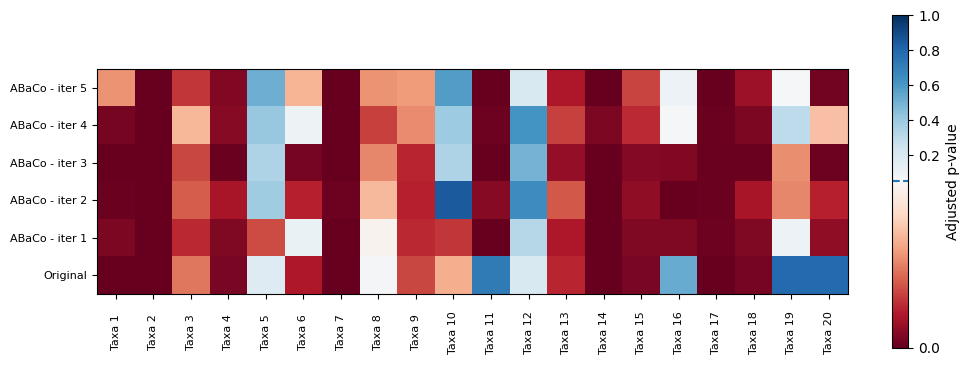

In [43]:
# Define top taxonomic groups on each dataset
dtu_data_clr = DataTransform(
    dtu_data, [dtu_sample_label, dtu_batch_label, dtu_bio_label], count=True
)


dtu_top_taxa = (
    dtu_data_clr.select_dtypes(include="number")
    .mean(axis=0)
    .sort_values(ascending=False)
    .index[:20]
)

dtu_kw_results = pd.DataFrame()

# Original
dtu_top_taxa_cols = dtu_data_clr.select_dtypes(include="number").columns.intersection(
    dtu_top_taxa
)
dtu_non_num_cols = dtu_data_clr.select_dtypes(exclude="number").columns
dtu_top_taxa_data = dtu_data_clr[list(dtu_non_num_cols) + list(dtu_top_taxa_cols)]

dtu_kw_results = pd.concat([dtu_kw_results, kruskal_wallis_taxa(dtu_top_taxa_data, dtu_sample_label, dtu_batch_label, dtu_bio_label, "Original")], axis = 0)

# ABaCo
for i in range(iter):
    recon_data = recons[i]
    recon_data_clr = DataTransform(
        recon_data, [dtu_sample_label, dtu_batch_label, dtu_bio_label], count=True
    )
    dtu_top_taxa_abaco_data = recon_data_clr[list(dtu_non_num_cols) + list(dtu_top_taxa_cols)]

    dtu_kw_results = pd.concat([dtu_kw_results, kruskal_wallis_taxa(dtu_top_taxa_abaco_data, dtu_sample_label, dtu_batch_label, dtu_bio_label, f"ABaCo - iter {i+1}")], axis = 0)

# Plot heatmap
heat_df = dtu_kw_results.pivot(index="method", columns="taxa", values="p_adj").reindex(index=dtu_kw_results["method"].drop_duplicates().tolist())

vmin = 0
vmax = 1
mid = 0.05

norm = TwoSlopeNorm(vmin=vmin, vcenter=mid, vmax=vmax)
cmap = plt.get_cmap("RdBu")

n_rows, n_cols = heat_df.shape
x = np.arange(n_cols + 1)
y = np.arange(n_rows + 1)

cell_size = 0.3
fig_width = n_cols * cell_size
fig_height = n_rows * cell_size

fig, ax = plt.subplots(figsize=(fig_width + 4, fig_height + 2))

im = ax.pcolormesh(
    x, y, heat_df.values,
    norm=norm,
    cmap=cmap,
    shading="flat"
)

generic_labels = [f"Taxa {i+1}" for i in range(n_cols)]
ax.set_xticks(np.arange(n_cols) + 0.5)
ax.set_xticklabels(generic_labels, rotation=90, va='center', fontsize=8)

ax.set_yticks(np.arange(n_rows) + 0.5)
ax.set_yticklabels(heat_df.index, fontsize=8)
ax.set_aspect('equal')
ax.tick_params(axis='x', which='major', pad=24)

cbar = fig.colorbar(im, ax=ax, fraction=0.1)
cbar.set_label('Adjusted p-value')
cbar.ax.hlines(mid, *cbar.ax.get_xlim(), linestyles='--')

plt.tight_layout()
plt.show()

## ABaCo results on benchmark datasets - multiple runs robustness analysis

### Correcting data with other methods

In [5]:
# Other methods
other_runs_clr = []

# Data CLR transformation to handle reconstruction methods
ad_count_data_clr = DataTransform(data = ad_count_data, factors=[ad_count_sample_label, ad_count_batch_label, ad_count_bio_label], transformation="CLR", count=True)
ibd_data_clr = DataTransform(data = ibd_data, factors=[ibd_sample_label, ibd_batch_label, ibd_bio_label], transformation="CLR", count=True)
dtu_data_clr = DataTransform(data = dtu_data, factors=[dtu_sample_label, dtu_batch_label, dtu_bio_label], transformation="CLR", count=True)

datasets = [
    ("AD_count", ad_count_data_clr, "Original"),
    ("IBD", ibd_data_clr, "Original"),
    ("DTU-GE", dtu_data_clr, "Original"),
]

run_format = [
    {"iter": 0, "dataset": name, "run": data, "prior": prior, "path": ""}
    for name, data, prior in datasets
]

other_runs_clr.extend(run_format)

# BMC correction
ad_recon_bmc = correctBMC(data = ad_count_data_clr, sample_label=ad_count_sample_label, batch_label=ad_count_batch_label, exp_label=ad_count_bio_label)
ibd_recon_bmc = correctBMC(data = ibd_data_clr, sample_label=ibd_sample_label, batch_label=ibd_batch_label, exp_label=ibd_bio_label)
dtu_recon_bmc = correctBMC(data = dtu_data_clr, sample_label=dtu_sample_label, batch_label=dtu_batch_label, exp_label=dtu_bio_label)
print("BMC ready")

datasets = [
    ("AD_count", ad_recon_bmc, "BMC"),
    ("IBD", ibd_recon_bmc, "BMC"),
    ("DTU-GE", dtu_recon_bmc, "BMC"),
]

run_format = [
    {"iter": 0, "dataset": name, "run": data, "prior": prior, "path": ""}
    for name, data, prior in datasets
]

other_runs_clr.extend(run_format)

# ComBat correction
ad_recon_combat = correctCombat(data = ad_count_data_clr, sample_label=ad_count_sample_label, batch_label=ad_count_batch_label, experiment_label=ad_count_bio_label)
ibd_recon_combat = correctCombat(data = ibd_data_clr, sample_label=ibd_sample_label, batch_label=ibd_batch_label, experiment_label=ibd_bio_label)
dtu_recon_combat = correctCombat(data = dtu_data_clr, sample_label=dtu_sample_label, batch_label=dtu_batch_label, experiment_label=dtu_bio_label)
print("ComBat ready")

datasets = [
    ("AD_count", ad_recon_combat, "ComBat"),
    ("IBD", ibd_recon_combat, "ComBat"),
    ("DTU-GE", dtu_recon_combat, "ComBat"),
]

run_format = [
    {"iter": 0, "dataset": name, "run": data, "prior": prior, "path": ""}
    for name, data, prior in datasets
]

other_runs_clr.extend(run_format)

# limma correction
ad_recon_limma = correctLimma_rBE(data = ad_count_data_clr, sample_label=ad_count_sample_label, batch_label=ad_count_batch_label, covariates_labels=ad_count_bio_label)
ibd_recon_limma = correctLimma_rBE(data = ibd_data_clr, sample_label=ibd_sample_label, batch_label=ibd_batch_label, covariates_labels=ibd_bio_label)
dtu_recon_limma = correctLimma_rBE(data = dtu_data_clr, sample_label=dtu_sample_label, batch_label=dtu_batch_label, covariates_labels=dtu_bio_label)
print("limma ready")

datasets = [
    ("AD_count", ad_recon_limma, "limma"),
    ("IBD", ibd_recon_limma, "limma"),
    ("DTU-GE", dtu_recon_limma, "limma"),
]

run_format = [
    {"iter": 0, "dataset": name, "run": data, "prior": prior, "path": ""}
    for name, data, prior in datasets
]

other_runs_clr.extend(run_format)

# PLSDA-batch correction
ad_recon_plsda = correctPLSDAbatch_R(df = ad_count_data_clr, sample_label=ad_count_sample_label, batch_label=ad_count_batch_label, exp_label=ad_count_bio_label, ncomp_bat=5, ncomp_trt=2)
ibd_recon_plsda = correctPLSDAbatch_R(df = ibd_data_clr, sample_label=ibd_sample_label, batch_label=ibd_batch_label, exp_label=ibd_bio_label, ncomp_bat=2, ncomp_trt=3)
dtu_recon_plsda = correctPLSDAbatch_R(df = dtu_data_clr, sample_label=dtu_sample_label, batch_label=dtu_batch_label, exp_label=dtu_bio_label, ncomp_bat=2, ncomp_trt=3)
print("PLSDA-batch ready")

datasets = [
    ("AD_count", ad_recon_plsda, "PLSDA-batch"),
    ("IBD", ibd_recon_plsda, "PLSDA-batch"),
    ("DTU-GE", dtu_recon_plsda, "PLSDA-batch"),
]

run_format = [
    {"iter": 0, "dataset": name, "run": data, "prior": prior, "path": ""}
    for name, data, prior in datasets
]

other_runs_clr.extend(run_format)

# ComBat-seq correction
ad_recon_combatseq = correctCombatSeq(data = ad_count_data, sample_label=ad_count_sample_label, batch_label=ad_count_batch_label, condition_label=ad_count_bio_label)
ad_recon_combatseq_clr = DataTransform(data = ad_recon_combatseq, factors=[ad_count_sample_label, ad_count_batch_label, ad_count_bio_label], transformation="CLR", count=True)
ibd_recon_combatseq = correctCombatSeq(data = ibd_data, sample_label=ibd_sample_label, batch_label=ibd_batch_label, condition_label=ibd_bio_label)
ibd_recon_combatseq_clr = DataTransform(data = ibd_recon_combatseq, factors=[ibd_sample_label, ibd_batch_label, ibd_bio_label], transformation="CLR", count=True)
dtu_recon_combatseq = correctCombatSeq(data = dtu_data, sample_label=dtu_sample_label, batch_label=dtu_batch_label, condition_label=dtu_bio_label)
dtu_recon_combatseq_clr = DataTransform(data = dtu_recon_combatseq, factors=[dtu_sample_label, dtu_batch_label, dtu_bio_label], transformation="CLR", count=True)
print("ComBat-seq ready")

datasets = [
    ("AD_count", ad_recon_combatseq_clr, "ComBat-seq"),
    ("IBD", ibd_recon_combatseq_clr, "ComBat-seq"),
    ("DTU-GE", dtu_recon_combatseq_clr, "ComBat-seq"),
]

run_format = [
    {"iter": 0, "dataset": name, "run": data, "prior": prior, "path": ""}
    for name, data, prior in datasets
]

other_runs_clr.extend(run_format)

# ConQuR correction
ad_recon_conqur = correctConQuR(df = ad_count_data, batch_cols=[ad_count_batch_label], covariate_cols=[ad_count_bio_label])
ad_recon_conqur_clr = DataTransform(data = ad_recon_conqur, factors=[ad_count_sample_label, ad_count_batch_label, ad_count_bio_label], transformation="CLR", count=True)
ibd_recon_conqur = correctConQuR(df = ibd_data, batch_cols=[ibd_batch_label], covariate_cols=[ibd_bio_label])
ibd_recon_conqur_clr = DataTransform(data = ibd_recon_conqur, factors=[ibd_sample_label, ibd_batch_label, ibd_bio_label], transformation="CLR", count=True)
dtu_recon_conqur = correctConQuR(df = dtu_data.drop(columns="sample_id"), batch_cols=[dtu_batch_label], covariate_cols=[dtu_bio_label])
dtu_recon_conqur_clr = DataTransform(data = dtu_recon_conqur, factors=[dtu_sample_label, dtu_batch_label, dtu_bio_label], transformation="CLR", count=True)
print("ConQuR ready")

datasets = [
    ("AD_count", ad_recon_conqur_clr, "ConQuR"),
    ("IBD", ibd_recon_conqur_clr, "ConQuR"),
    ("DTU-GE", dtu_recon_conqur_clr, "ConQuR"),
]

run_format = [
    {"iter": 0, "dataset": name, "run": data, "prior": prior, "path": ""}
    for name, data, prior in datasets
]

other_runs_clr.extend(run_format)

other_runs_clr = pd.DataFrame(other_runs_clr)

BMC ready
Found 5 batches.
Adjusting for 1 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Found 2 batches.
Adjusting for 2 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Found 2 batches.
Adjusting for 3 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
ComBat ready
limma ready
PLSDA-batch ready
ComBat-seq ready
ConQuR ready


### Defining auxiliary function for ARI

In [9]:
# Defining ARI with GMM 
def ARI_GMM(data, interest_label="tissue", n_clusters=None):

    data_otus = data.select_dtypes(include="number")  # OTUs
    data_bio = data[interest_label]  # Labels

    if n_clusters == None:
        gmm = GaussianMixture(
            n_components=len(set(data_bio)), random_state=42, covariance_type="full"
        )  # GMM clustering
    else:
        gmm = GaussianMixture(
            n_clusters=n_clusters, random_state=42, covariance_type="full"
        )  # GMM clustering w/ n clusters

    gmm.fit(data_otus) # Fitting model to data
    predicted_clusters = gmm.predict(data_otus)  # Predicting label of cluster

    ari = adjusted_rand_score(data_bio, predicted_clusters)  # ARI
    return ari

### Compute batch effect correction metrics - other methods

In [14]:
from tqdm import tqdm

datasets = ["AD_count", "IBD", "DTU-GE"]
batch_label = ["batch", "project ID", "pipeline"]

for idx, entry in tqdm(other_runs_clr.iterrows(), total=other_runs_clr.shape[0]):
    run = entry["run"]
    dataset = entry["dataset"]
    i = datasets.index(dataset)
    # Compute batch correction metrics
    kbet = kBET(run, batch_label=batch_label[i])
    ilisi = iLISI_norm(run, batch_label=batch_label[i])
    asw = 1 - abs(ASW(run, interest_label=batch_label[i]))
    ari = 1 - ARI_GMM(run, interest_label=batch_label[i])

    other_runs_clr.at[idx, "kBET"] = kbet
    other_runs_clr.at[idx, "iLISI"] = ilisi
    other_runs_clr.at[idx, "ASW"] = asw
    other_runs_clr.at[idx, "ARI"] = ari

other_runs_clr["kBET error"] = 0.0
other_runs_clr["iLISI error"] = 0.0
other_runs_clr["ASW error"] = 0.0
other_runs_clr["ARI error"] = 0.0

100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


### Loading ABaCo runs

In [ ]:
global_path = "performance_metrics"
method = "meta_multi_runs"

datasets = ["AD_count", "IBD", "DTU-GE"]
dataset_labels = ["Anaerobic digestion dataset", "Inflammatory Bowel Disease dataset", "DTU-GE dataset"]
priors = ["vmm", "mog"]
prior_labels = ["ABaCo - VMM prior", "ABaCo - MoG prior"]
mult = 1
bio_label = ["trt", "associated phenotype", "location"]
sample_label = ["sample", "run ID", "accession"]
batch_label = ["batch", "project ID", "pipeline"]

multi_runs = []
multi_runs_clr = []

for j, dataset in enumerate(datasets):

    path = f"{global_path}/{method}/{dataset}"

    for k, prior in enumerate(priors):

        file_paths = [
            os.path.join(path, file)
            for file in os.listdir(path)
            if file.startswith(f"{prior}")
            and os.path.isfile(os.path.join(path, file))
            and re.search(r"model_\d+$", os.path.splitext(file)[0])
        ]
    
        for i, file in enumerate(file_paths):
                run = DataPreprocess(path = file, factors = [sample_label[j], batch_label[j], bio_label[j]])
                run_format = {
                    "iter":i,
                    "dataset": dataset,
                    "run": run,
                    "prior": prior,
                    "path":file,
                }
                multi_runs.append(run_format)
        
        for i, file in enumerate(file_paths):
                run = DataTransform(DataPreprocess(path = file, factors = [sample_label[j], batch_label[j], bio_label[j]]), factors = [sample_label[j], batch_label[j], bio_label[j]], count=True)
                run_format = {
                    "iter":i,
                    "dataset": dataset,
                    "run": run,
                    "prior": prior,
                    "path":file,
                }
                multi_runs_clr.append(run_format)

multi_runs = pd.DataFrame(multi_runs)
multi_runs_clr = pd.DataFrame(multi_runs_clr)

### Compute batch effect correction metrics - ABaCo runs

In [8]:
from tqdm import tqdm

for idx, entry in tqdm(multi_runs_clr.iterrows(), total=multi_runs_clr.shape[0]):
    run = entry["run"]
    dataset = entry["dataset"]
    i = datasets.index(dataset)
    # Compute batch correction metrics
    kbet = kBET(run, batch_label=batch_label[i])
    ilisi = iLISI_norm(run, batch_label=batch_label[i])
    asw = 1 - abs(ASW(run, interest_label=batch_label[i]))
    ari = 1 - ARI_GMM(run, interest_label=batch_label[i])

    multi_runs_clr.at[idx, "kBET"] = kbet
    multi_runs_clr.at[idx, "iLISI"] = ilisi
    multi_runs_clr.at[idx, "ASW"] = asw
    multi_runs_clr.at[idx, "ARI"] = ari

100%|██████████| 300/300 [04:03<00:00,  1.23it/s]


### Get the mean and std for metrics

In [19]:
abaco_results = pd.DataFrame()
prior_labels = ["ABaCo - VMM prior", "ABaCo - MoG prior"]

for dataset in datasets:
    for j, prior in enumerate(priors):
        runs = multi_runs_clr[(multi_runs_clr["prior"] == prior) & (multi_runs_clr["dataset"] == dataset)]

        kbet_mean, kbet_std = np.mean(runs["kBET"]), np.std(runs["kBET"])
        ilisi_mean, ilisi_std = np.mean(runs["iLISI"]), np.std(runs["iLISI"])
        asw_mean, asw_std = np.mean(runs["ASW"]), np.std(runs["ASW"])
        ari_mean, ari_std = np.mean(runs["ARI"]), np.std(runs["ARI"])
    
        run_format = {
                        "iter":0,
                        "dataset": dataset,
                        "run": "n/a",
                        "prior": f"{prior_labels[j]}",
                        "path": "",
                        "kBET": kbet_mean,
                        "iLISI": ilisi_mean,
                        "ASW": asw_mean,
                        "ARI": ari_mean,
                        "kBET error": kbet_std,
                        "iLISI error": ilisi_std,
                        "ASW error": asw_std,
                        "ARI error": ari_std,
                    }
        
        abaco_results = pd.concat([abaco_results, pd.DataFrame([run_format])], axis = 0)

### Concatenate with other methods

In [ ]:
batch_results = pd.concat([other_runs_clr, abaco_results], axis=0)

,iter,dataset,run,prior,path,kBET,iLISI,ASW,ARI,error,kBET error,iLISI error,ASW error,ARI error
0,0,AD_count,sample batch trt Cluster_12 C...,Original,,0.306667,0.182354,0.880051,0.729910,0.0,0.000000,0.000000,0.000000,0.000000
1,0,IBD,run ID project ID associated phenot...,Original,,0.131528,0.210496,0.844734,0.990264,0.0,0.000000,0.000000,0.000000,0.000000
2,0,DTU-GE,accession pipeline location Archaea C...,Original,,0.069767,0.060644,0.731499,0.288255,0.0,0.000000,0.000000,0.000000,0.000000
3,0,AD_count,sample trt batch Cluster_12 C...,BMC,,0.653333,0.333282,0.889182,0.977407,0.0,0.000000,0.000000,0.000000,0.000000
4,0,IBD,run ID associated phenotype project...,BMC,,0.255319,0.170947,0.927095,0.973475,0.0,0.000000,0.000000,0.000000,0.000000
5,0,DTU-GE,accession location pipeline Archaea C...,BMC,,0.457364,0.374329,0.996482,1.004840,0.0,0.000000,0.000000,0.000000,0.000000
6,0,AD_count,sample batch trt Cluster_12 C...,ComBat,,0.653333,0.410344,0.879032,1.008354,0.0,0.000000,0.000000,0.000000,0.000000
7,0,IBD,run ID project ID associated phenot...,ComBat,,0.578337,0.466645,0.996789,0.989587,0.0,0.000000,0.000000,0.000000,0.000000
8,0,DTU-GE,accession pipeline location Archaea C...,ComBat,,0.519380,0.456061,0.995923,1.003001,0.0,0.000000,0.000000,0.000000,0.000000
9,0,AD_count,sample batch trt Cluster_12 C...,limma,,0.720000,0.346538,0.895443,1.003524,0.0,0.000000,0.000000,0.000000,0.000000


### Plot 1: Barplot with batch effect correction metrics

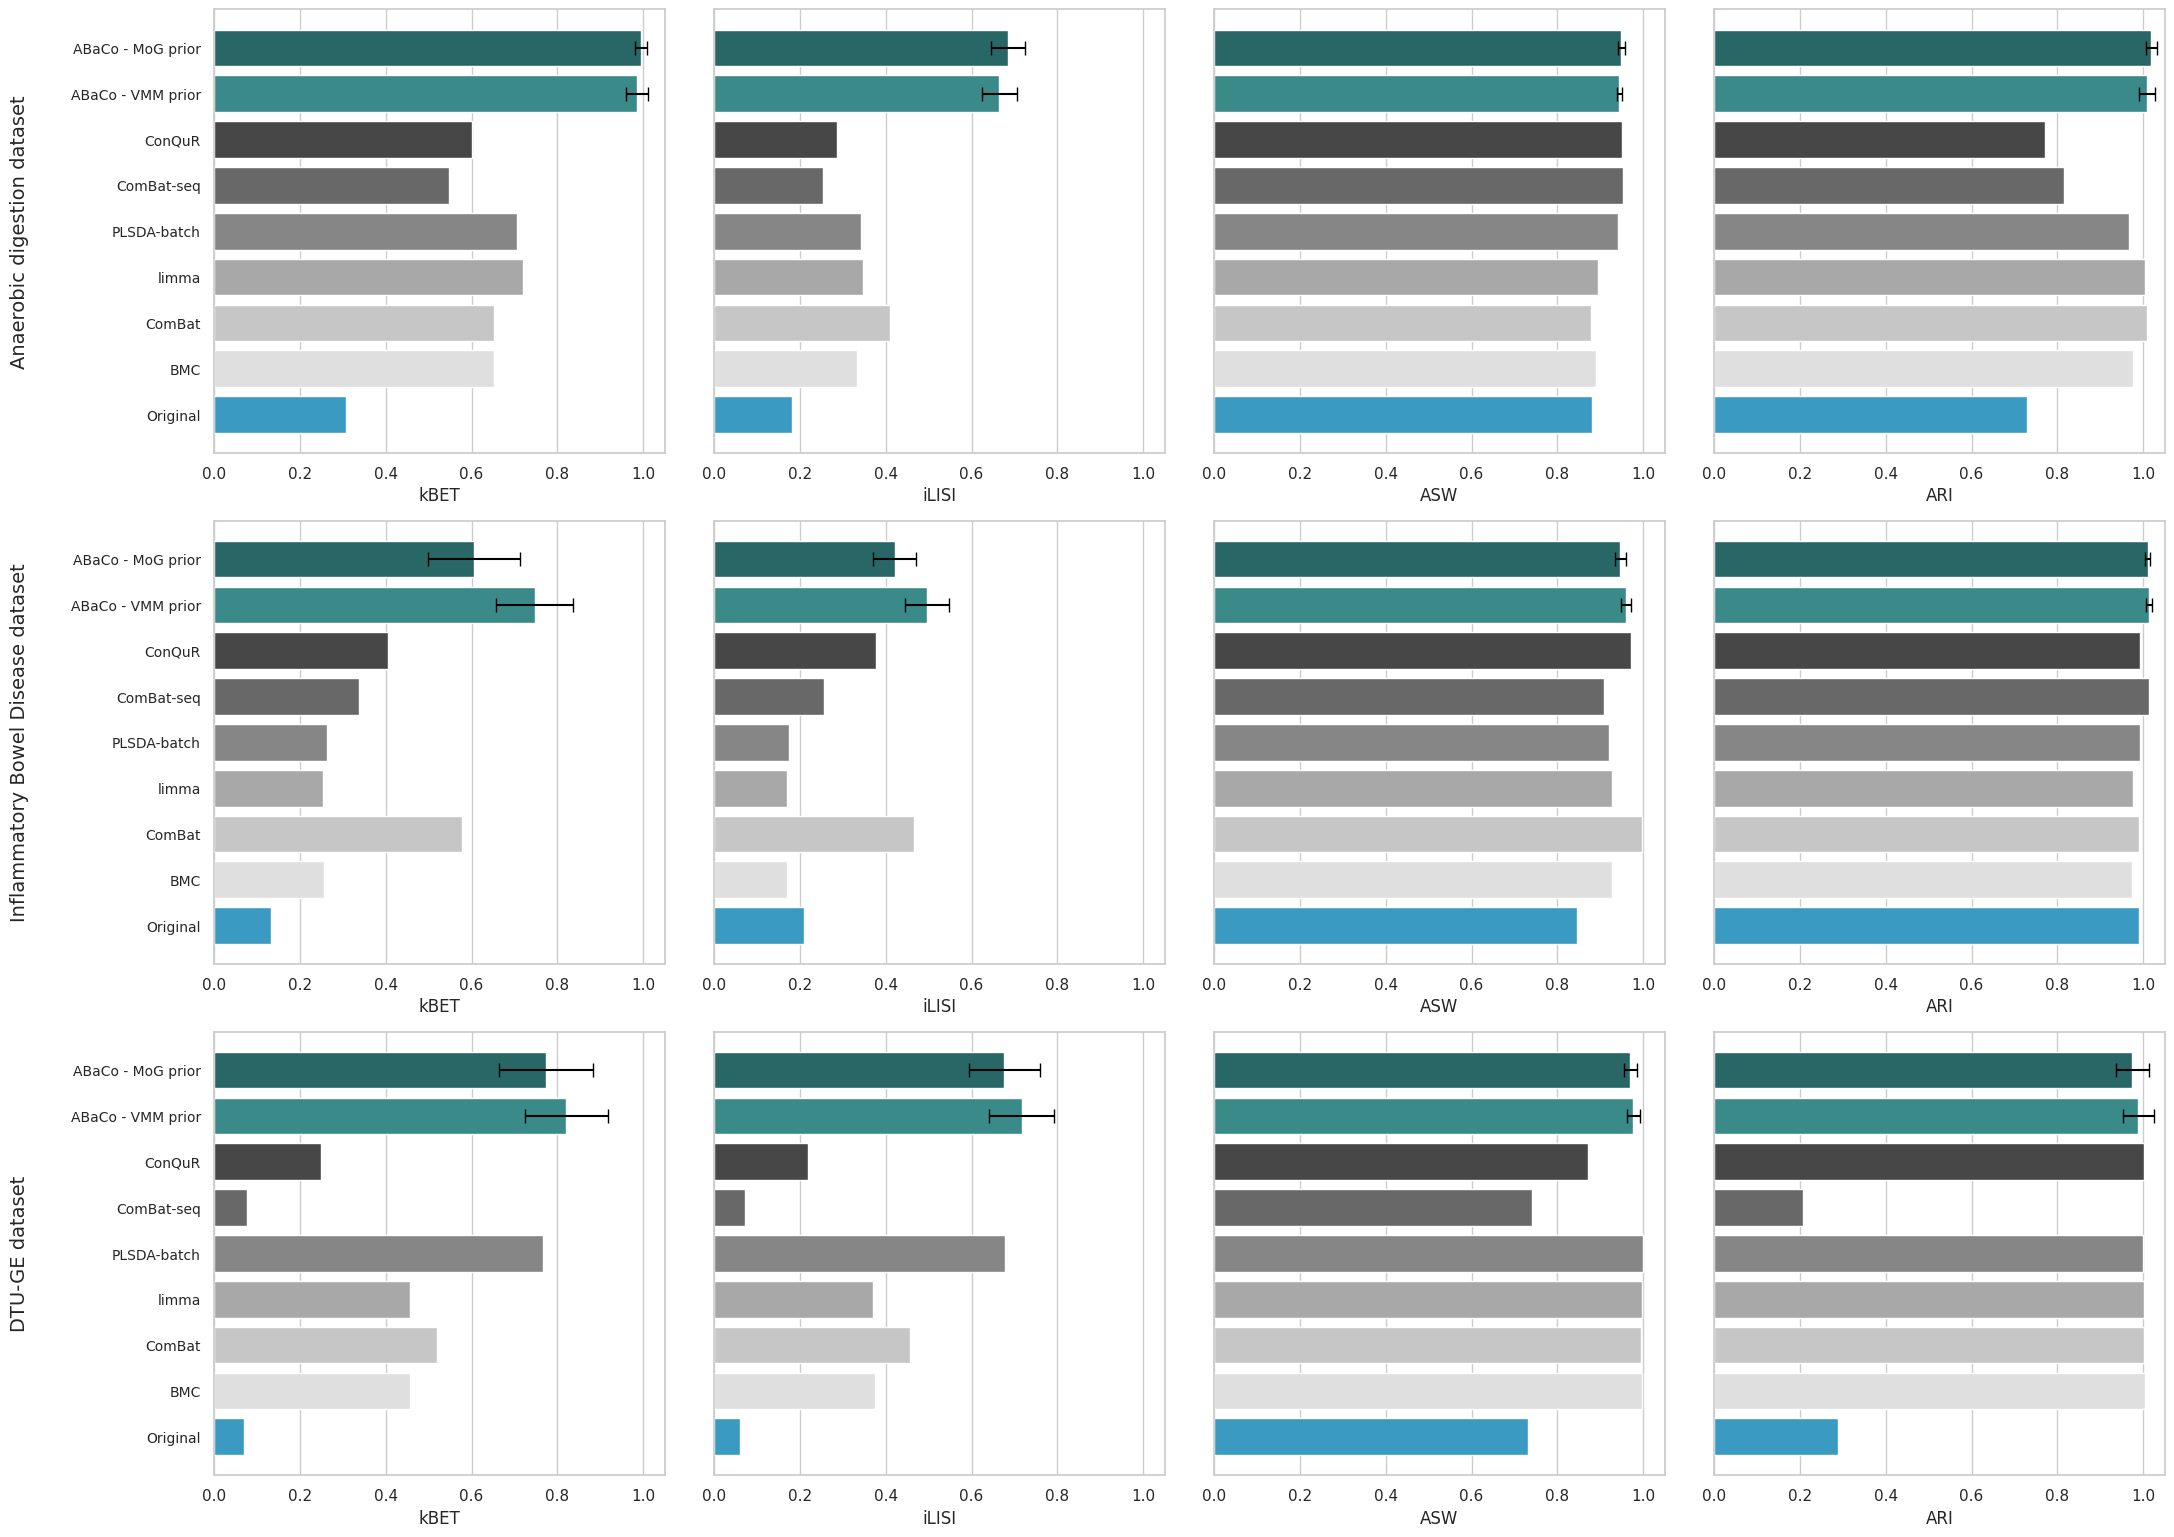

In [46]:
metrics    = ["kBET", "iLISI", "ASW", "ARI"]
error_cols = {m: f"{m} error" for m in metrics}
datasets   = batch_results["dataset"].unique()

sns.set(style="whitegrid")

# Custom palettes
muted     = sns.color_palette("Greys", n_colors=8)[1:7]
highlight = ["#2D9797", "#1F7171"]
base      = ["#24A4D8"]

fig, axes = plt.subplots(len(datasets), len(metrics),
                         figsize=(20, 15), sharex=False)
fig.tight_layout(pad=0, h_pad=2)

# Add padding between y-label and plot
for ax in axes[:, 0]:
    ax.yaxis.labelpad = 30

for i, ds in enumerate(datasets):
    df_ds = batch_results[batch_results["dataset"] == ds]
    methods = df_ds["prior"].tolist()

    # Build color mapping
    palette_map = {}
    muted_idx = 0
    highlight_idx = 0

    for method in methods:
        if method == "Original":
            palette_map[method] = base[0]
        elif method.startswith("ABaCo"):
            # cycle through highlight colors
            palette_map[method] = highlight[highlight_idx % len(highlight)]
            highlight_idx += 1
        else:
            palette_map[method] = muted[muted_idx % len(muted)]
            muted_idx += 1

    for j, m in enumerate(metrics):
        ax = axes[i, j]

        # 2) Draw bars with seaborn, no internal CI
        sns.barplot(
            x=m, y="prior", data=df_ds,
            order=df_ds["prior"],
            ci=None,
            palette=palette_map,
            ax=ax
        )
        ax.invert_yaxis()     # highest on top
        ax.set_xlabel(m)
        if m == "ARI":
            ax.set_xlim(0, 1.05)
        else:
            ax.set_xlim(0, 1.05)

        # 3) Overlay your explicit error‐bars for ABaCo methods
        for y_pos, (_, row) in enumerate(df_ds.iterrows()):
            if row["prior"].startswith("ABaCo"):
                ax.errorbar(
                    x=row[m],
                    y=y_pos,
                    xerr=row[error_cols[m]],
                    fmt="none",
                    capsize=5,
                    ecolor="black",
                )

        # 4) Only label the first column with the dataset name
        if j == 0:
            ax.set_ylabel(dataset_labels[i], fontsize=14)
            ax.tick_params(axis='y', labelsize=10)
            # ax.tick_params(axis='x', labelsize=12)
        else:
            ax.set_ylabel("")
            ax.tick_params(left=False, labelleft=False)

plt.show()

### Kruskal-wallis test

In [48]:
# Define function to compute Kruskal-Wallis per taxa
def kruskal_wallis_taxa(df, sample_label, batch_label, bio_label, method):
    # Melt dataframe
    melt_df = pd.melt(df, id_vars = [sample_label, batch_label, bio_label], var_name = "taxa", value_name = "norm_counts")
    # Comput K-W test
    results = []
    # Per taxa
    for taxon, df_taxa in melt_df.groupby("taxa"):
        # For each biological group
        groups = []

        for grp, df_grp in df_taxa.groupby(bio_label):

            groups.append(df_grp["norm_counts"].values)

        try:
            stat, pval = kruskal(*groups)
            
        except ValueError:
            continue

        results.append({"taxa":taxon,
                        "H_stat":stat,
                        "p-value":pval})

    kw_df = pd.DataFrame(results)

    rej, p_adj, _, _ = multipletests(kw_df["p-value"], method = "fdr_bh")
    kw_df["p_adj"] = p_adj
    kw_df["significant"] = rej
    kw_df["method"] = method
    return kw_df

### Plot 2: K-W test for ABaCo multiple runs on top taxonomic groups

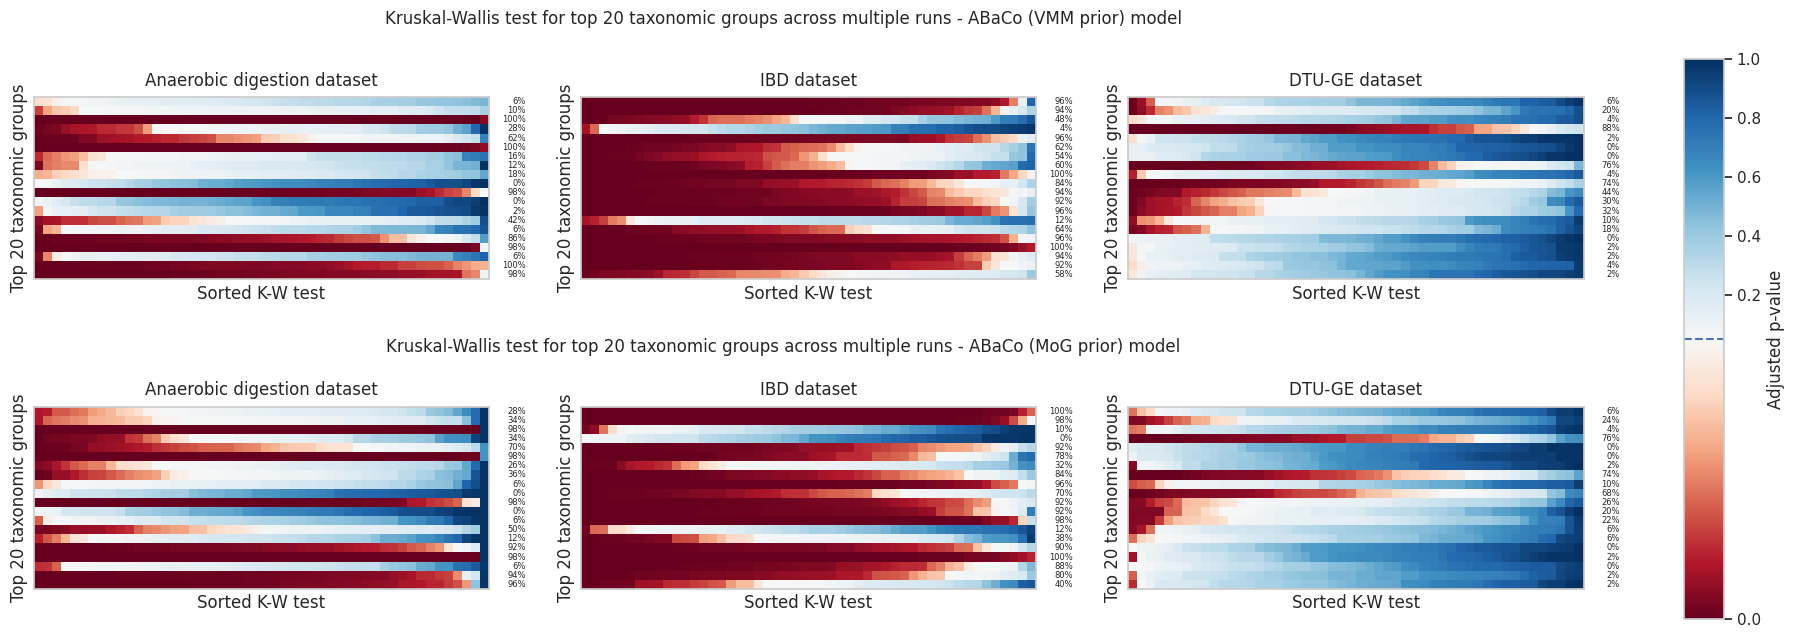

In [50]:
priors = ["vmm", "mog"]
prior_labels = ["ABaCo (VMM prior)", "ABaCo (MoG prior)"]
dataset_labels = ["Anaerobic digestion dataset", "IBD dataset","DTU-GE dataset"]

# Define top taxonomic groups on each dataset
ad_top_taxa = ad_count_data_clr.select_dtypes(include = "number").mean(axis=0).sort_values(ascending=False).index[:20]
ibd_top_taxa = ibd_data_clr.select_dtypes(include = "number").mean(axis=0).sort_values(ascending=False).index[:20]
dtu_top_taxa = dtu_data_clr.select_dtypes(include = "number").mean(axis=0).sort_values(ascending=False).index[:20]

# Original
ad_top_taxa_cols = ad_count_data_clr.select_dtypes(include = "number").columns.intersection(ad_top_taxa)
ad_non_num_cols = ad_count_data_clr.select_dtypes(exclude = "number").columns

ibd_top_taxa_cols = ibd_data_clr.select_dtypes(include = "number").columns.intersection(ibd_top_taxa)
ibd_non_num_cols = ibd_data_clr.select_dtypes(exclude = "number").columns

dtu_top_taxa_cols = dtu_data_clr.select_dtypes(include = "number").columns.intersection(dtu_top_taxa)
dtu_non_num_cols = dtu_data_clr.select_dtypes(exclude = "number").columns

top_taxa_cols = [ad_top_taxa_cols, ibd_top_taxa_cols, dtu_top_taxa_cols]
non_num_cols = [ad_non_num_cols, ibd_non_num_cols, dtu_non_num_cols]
top_taxa_lists = [ad_top_taxa, ibd_top_taxa, dtu_top_taxa]


fig, axes = plt.subplots(2, 3, figsize=(20, 8), sharex=True, sharey=True)

for j, prior in enumerate(priors):

    for i, dataset in enumerate(datasets):

        abaco_runs = multi_runs[(multi_runs["dataset"] == dataset) & (multi_runs["prior"] == prior)]
        
        kw_results_abaco = pd.DataFrame()

        for k, abaco_run in enumerate(abaco_runs["run"]):

            recon_data = DataTransform(abaco_run, factors = [sample_label[i], batch_label[i], bio_label[i]], count = True)

            top_taxa_abaco_data = recon_data[list(non_num_cols[i]) + list(top_taxa_cols[i])]
            kw_results_abaco = pd.concat([kw_results_abaco, kruskal_wallis_taxa(top_taxa_abaco_data, sample_label[i], batch_label[i], bio_label[i], k)], axis = 0)
        
        heat_df = kw_results_abaco.pivot(index="method", columns="taxa", values="p_adj").reindex(index = kw_results_abaco["method"].drop_duplicates().tolist()) 

        heat_sorted = heat_df.copy()

        heat_sorted.iloc[:,:] = np.sort(heat_df.values, axis=0)

        heat_df = heat_sorted

        heat_df = heat_df.T

        heat_df = heat_df.reindex(index=top_taxa_lists[i])

        pct = (
            kw_results_abaco
              .groupby("taxa")["p_adj"]
              .apply(lambda x: (x < 0.05).mean() * 100)
        )
        # reindex into the exact row‐order of your heatmap
        pct = pct.reindex(top_taxa_lists[i]).fillna(0)

        vmin = 0.00
        vmax = 1.00
        mid = 0.05

        norm = TwoSlopeNorm(vmin = vmin, vcenter = mid, vmax = vmax)
        cmap = plt.get_cmap("RdBu")

        n_rows, n_cols = heat_df.shape

        x = np.arange(n_cols + 1)
        y = np.arange(n_rows + 1)

        cell_size = 0.3
        fig_width  = n_cols * cell_size
        fig_height = n_rows * cell_size

        ax = axes[j][i]

        im = ax.pcolormesh(
            x, y, heat_df.values, 
            norm=norm,
            cmap=cmap,
            shading="flat")

        for row_idx, taxon in enumerate(pct.index):
            ax.text(
                x= n_cols + 0.08*n_cols,        # a little to the right of the last cell
                y=row_idx + 0.5,         # centered in each cell 
                s=f"{pct[taxon]:.0f}%",  # integer percent
                va="center", 
                ha="right",
                fontsize=6,
                transform=ax.transData  # data‐coordinates
            )

        n_cols = heat_df.shape[1]
        generic_labels = [f"Taxa {i+1}" for i in range(n_cols)]
        # ax.set_xticks(np.arange(n_cols) + 0.5)
        # ax.set_xticklabels(generic_labels, rotation=90, va='center', fontsize=8)

        # ax.set_yticks(np.arange(n_rows) + 0.5)
        # ax.set_yticklabels(heat_df.index, fontsize=8)
        ax.set_aspect('equal')
        ax.tick_params(axis='x', which='major', pad=24)

        # cbar = fig.colorbar(im, ax=ax, fraction=0.1)
        # cbar.set_label('Adjusted p-value')
        # cbar.ax.hlines(mid, *cbar.ax.get_xlim(), linestyles='--')

        ax.set_ylabel("Top 20 taxonomic groups")
        ax.set_xlabel("Sorted K-W test")



for i, ax_row in enumerate(axes):
    row_title = f"Kruskal-Wallis test for top 20 taxonomic groups across multiple runs - {prior_labels[i]} model"

    fig.text(
        0.5,
        0.90 - i*0.41,
        row_title,
        ha="center",
        va = "center",
        fontsize=12,
    )

    for j, ax in enumerate(ax_row):
        ax.set_title(dataset_labels[j],
                     pad=8,
                     fontsize=12)
        
        ax.tick_params(
            left=False,
            bottom=False,
            labelleft=False,
            labelbottom=False
        )

fig.subplots_adjust(
    top=0.88,
    wspace=0.2,
    hspace=0.01
)

cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])

cbar = fig.colorbar(im, cax=cax, fraction=0.1)
cbar.set_label('Adjusted p-value')
cbar.ax.hlines(mid, *cbar.ax.get_xlim(), linestyles='--')

plt.show()

## Into simulated data

### Creating simulated data

In [14]:
# Define random seed
np.random.seed(42)

n_samples = 100
n_features = 500
p_diff = 0.5
b_diff = 0.1

n_diff = int(n_features * p_diff)
b_diff = int(n_features * b_diff)

batches = ["Batch 1", "Batch 2"]
bios = ["A", "B"]

# Start several simulation data
sims = 50
sim_data_no_bt = []
sim_data_no_b = []
sim_data_no_t = []
sim_data_bt = []

for i in range(sims):

    # Build metadata
    metadata = pd.DataFrame({
        "SampleID": [f"S{i+1}" for i in range(n_samples)],
        "Condition": np.random.choice(bios, size=n_samples, replace=True),
        "Batch": np.random.choice(batches, size=n_samples, replace=True)
    })

    # Simulation settings per feature
    r = np.random.uniform(1.0, 3.0, size=n_features) # Dispersion
    z_target = np.random.uniform(0.1, 0.5, n_features)  # e.g. 20–50% zeros

    # Baseline log-abundance and true effects
    baseline_log = np.random.normal(loc=2, scale=1, size=n_features)

    # compute per‐feature NB zero probability
    mu = np.exp(baseline_log)
    p  = r / (r + mu)
    nb_zero = p**r

    # invert for p_zero
    p_zero = (z_target - nb_zero) / (1 - nb_zero)
    p_zero = np.clip(p_zero, 0, 1)

    # Biological effect
    effect_sizes = np.zeros(n_features)
    effect_idx = np.random.choice(n_features, n_diff, replace = False)
    effect_sizes[effect_idx] = np.random.normal(loc=2.0, scale = 2.0, size=n_diff)

    # Batch effect
    batch_sizes = np.zeros(n_features)
    batch_idx = np.random.choice(n_features, b_diff, replace = False)
    batch_sizes[batch_idx] = np.random.normal(loc=1.0, scale = 2.0, size=b_diff)

    # Simulating counts without biological effect
    counts = np.zeros((len(metadata), n_features), dtype=int)
    counts_batch = np.zeros((len(metadata), n_features), dtype=int)
    for i, row in metadata.iterrows():
        mu = baseline_log
        mu_batch = mu + (batch_sizes if row["Batch"]==batches[1] else 0) # Batch shift on Batch 2
        p = r / (r + np.exp(mu))
        p_batch = r / (r + np.exp(mu_batch))
        is_zero = np.random.binomial(1, p_zero)
        counts_i = nbinom(r, p).rvs()
        counts[i, :] = np.where(is_zero==1, 0, counts_i)
        counts_i_batch = nbinom(r, p_batch).rvs()
        counts_batch[i, :] = np.where(is_zero==1, 0, counts_i_batch)
    
    # Case 1: No batch, no bio
    count_matrix_no_bt = pd.DataFrame(counts, columns = [f"OTU{j+1}" for j in range(n_features)])
    count_matrix_no_bt = pd.concat([metadata, count_matrix_no_bt], axis = 1)
    # Case 2: Batch, no bio
    count_matrix_no_t = pd.DataFrame(counts_batch, columns = [f"OTU{j+1}" for j in range(n_features)])
    count_matrix_no_t = pd.concat([metadata, count_matrix_no_t], axis = 1)

    sim_data_no_bt.append(count_matrix_no_bt)
    sim_data_no_t.append(count_matrix_no_t)
    
    # Simulating counts with biological effect
    counts = np.zeros((len(metadata), n_features), dtype=int)
    counts_batch = np.zeros((len(metadata), n_features), dtype=int)
    for i, row in metadata.iterrows():
        mu = baseline_log + (effect_sizes if row["Condition"]==bios[1] else 0) # Biological shift on group B
        mu_batch = mu + (batch_sizes if row["Batch"]==batches[1] else 0) # Batch shift on Batch 2
        p = r / (r + np.exp(mu))
        p_batch = r / (r + np.exp(mu_batch))
        is_zero = np.random.binomial(1, p_zero)
        counts_i = nbinom(r, p).rvs()
        counts[i, :] = np.where(is_zero==1, 0, counts_i)
        counts_i_batch = nbinom(r, p_batch).rvs()
        counts_batch[i, :] = np.where(is_zero==1, 0, counts_i_batch)
    
    # Case 3: No batch, bio
    count_matrix_no_b = pd.DataFrame(counts, columns = [f"OTU{j+1}" for j in range(n_features)])
    count_matrix_no_b = pd.concat([metadata, count_matrix_no_b], axis = 1)
    # Case 4: Batch, bio
    count_matrix_bt = pd.DataFrame(counts_batch, columns = [f"OTU{j+1}" for j in range(n_features)])
    count_matrix_bt = pd.concat([metadata, count_matrix_bt], axis = 1)

    sim_data_no_b.append(count_matrix_no_b)
    sim_data_bt.append(count_matrix_bt)

### Model setup

In [63]:
iter = 1
recons = []
for i in range(iter):
    print(f"Iter {i+1} / {iter} :")
    sim_data = sim_data_bt[i]
    plotPCoA(sim_data, sample_label="SampleID", batch_label = "Batch", experiment_label = "Condition")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = metaABaCo(sim_data, 2, "Condition", 2, "Batch", 500, device, prior = "VMM", pdist = "ZINB",
                    epochs=[5000, 1000, 1000])
    model.correct(adv_lr = 1e-5, disc_lr = 1e-5, phase_1_vae_lr=1e-4, phase_2_vae_lr=1e-5, phase_3_vae_lr=1e-5, w_elbo_nll=1, 
                  w_bio_penalty=100.0, w_cluster_penalty=100.0, seed=42)
    recon_data = model.reconstruct(seed=42)
    recons.append(recon_data)
    
    plotPCoA(recon_data, sample_label="SampleID", batch_label = "Batch", experiment_label = "Condition")

Iter 1 / 1 :


Training: VAE for learning meaningful embeddings: 100%|██████████| 5000/5000 [01:24<00:00, 59.36it/s, bio_penalty=0.0003, clustering_loss=0.0743, elbo=1397.1896, epoch=4999/5001, vae_loss=1397.2642]  
Training: Embeddings batch effect correction using adversrial training: 100%|██████████| 1000/1000 [00:18<00:00, 53.90it/s, adv_loss=-0.7060, bio_penalty=0.0000, clustering_loss=0.0000, disc_loss=0.7060, elbo=1423.2822, epoch=999/1001, vae_loss=1423.2822]
Training: VAE decoder with masked batch labels: 100%|██████████| 1000/1000 [00:09<00:00, 110.96it/s, cycle_loss=0.0000, epoch=1000/1000, vae_loss=1331.0881]


### PERMANOVA

In [27]:
def permanova_ait(df, sample_label, group_label):
    samples = df[sample_label].values
    groups = df[group_label].values
    clr_data = df.select_dtypes(include = "number").values

    aitch = pdist(clr_data, metric = "euclidean")
    dist_mat = squareform(aitch)
    dm = DistanceMatrix(dist_mat, ids=samples)

    res_ait = permanova(distance_matrix=dm, grouping=groups)

    res_ait["R2"] = (
        res_ait["test statistic"]
        * (len(np.unique(groups)) - 1)
        / (
            res_ait["test statistic"] * (len(np.unique(groups)) - 1)
            + (len(samples) - len(np.unique(groups)))
        )
    )
    return res_ait

(0.0, 1.0)

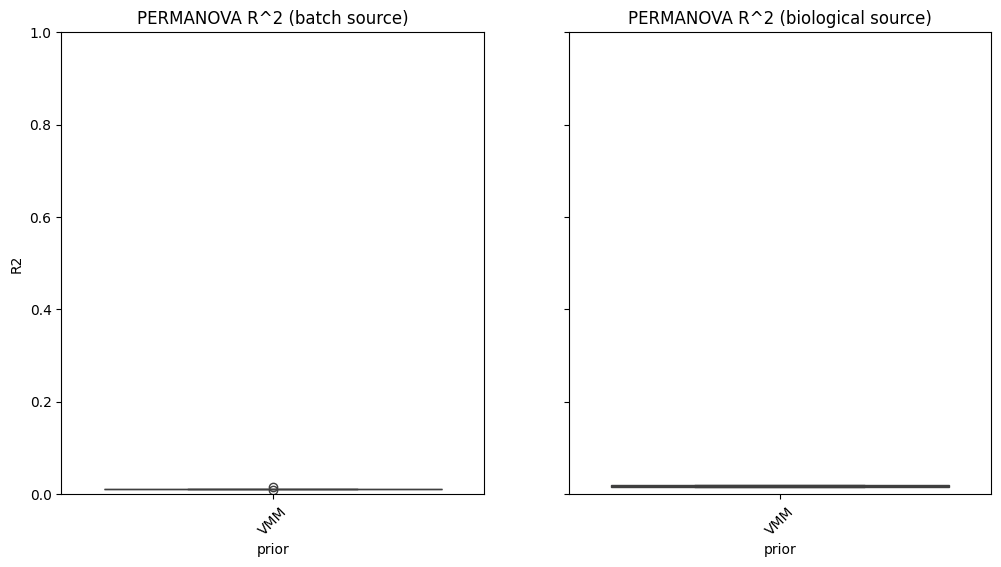

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

batch_permas = []
bio_permas = []

for i in range(iter):

    prior = "VMM"

    abaco_run = recons[i]

    recon_data = DataTransform(abaco_run, factors = ["SampleID", "Batch", "Condition"], count = True)

    batch_perma = permanova_ait(recon_data, "SampleID", "Batch")["R2"]
    bio_perma = permanova_ait(recon_data, "SampleID", "Condition")["R2"]

    batch_permas.append({"iter":i, "prior": prior, "R2": batch_perma})
    bio_permas.append({"iter":i, "prior": prior, "R2": bio_perma})


sns.boxplot(
data=pd.DataFrame(batch_permas),
x='prior',
y='R2',
ax=axes[0]
)
axes[0].set_title('PERMANOVA R^2 (batch source)')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(
data=pd.DataFrame(bio_permas),
x='prior',
y='R2',
ax=axes[1]
)
axes[1].set_title('PERMANOVA R^2 (biological source)')
axes[1].tick_params(axis='x', rotation=45)

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)

## Reviewing simulated data results

### Creating simulated data

In [62]:
# Define random seed
np.random.seed(42)

n_samples = 100
n_features = 500
p_diff = 0.5
b_diff = 0.1

n_diff = int(n_features * p_diff)
b_diff = int(n_features * b_diff)

batches = ["Batch 1", "Batch 2"]
bios = ["A", "B"]

# Start several simulation data
sims = 50
sim_data_no_bt = []
sim_data_no_b = []
sim_data_no_t = []
sim_data_bt = []

for i in range(sims):

    # Build metadata
    metadata = pd.DataFrame({
        "SampleID": [f"S{i+1}" for i in range(n_samples)],
        "Condition": np.random.choice(bios, size=n_samples, replace=True),
        "Batch": np.random.choice(batches, size=n_samples, replace=True)
    })

    # Simulation settings per feature
    r = np.random.uniform(1.0, 3.0, size=n_features) # Dispersion
    z_target = np.random.uniform(0.1, 0.5, n_features)  # e.g. 20–50% zeros

    # Baseline log-abundance and true effects
    baseline_log = np.random.normal(loc=2, scale=1, size=n_features)

    # compute per‐feature NB zero probability
    mu = np.exp(baseline_log)
    p  = r / (r + mu)
    nb_zero = p**r

    # invert for p_zero
    p_zero = (z_target - nb_zero) / (1 - nb_zero)
    p_zero = np.clip(p_zero, 0, 1)

    # Biological effect
    effect_sizes = np.zeros(n_features)
    effect_idx = np.random.choice(n_features, n_diff, replace = False)
    effect_sizes[effect_idx] = np.random.normal(loc=2.0, scale = 2.0, size=n_diff)

    # Batch effect
    batch_sizes = np.zeros(n_features)
    batch_idx = np.random.choice(n_features, b_diff, replace = False)
    batch_sizes[batch_idx] = np.random.normal(loc=1.0, scale = 2.0, size=b_diff)

    # Simulating counts without biological effect
    counts = np.zeros((len(metadata), n_features), dtype=int)
    counts_batch = np.zeros((len(metadata), n_features), dtype=int)
    for i, row in metadata.iterrows():
        mu = baseline_log
        mu_batch = mu + (batch_sizes if row["Batch"]==batches[1] else 0) # Batch shift on Batch 2
        p = r / (r + np.exp(mu))
        p_batch = r / (r + np.exp(mu_batch))
        is_zero = np.random.binomial(1, p_zero)
        counts_i = nbinom(r, p).rvs()
        counts[i, :] = np.where(is_zero==1, 0, counts_i)
        counts_i_batch = nbinom(r, p_batch).rvs()
        counts_batch[i, :] = np.where(is_zero==1, 0, counts_i_batch)
    
    # Case 1: No batch, no bio
    count_matrix_no_bt = pd.DataFrame(counts, columns = [f"OTU{j+1}" for j in range(n_features)])
    count_matrix_no_bt = pd.concat([metadata, count_matrix_no_bt], axis = 1)
    # Case 2: Batch, no bio
    count_matrix_no_t = pd.DataFrame(counts_batch, columns = [f"OTU{j+1}" for j in range(n_features)])
    count_matrix_no_t = pd.concat([metadata, count_matrix_no_t], axis = 1)

    sim_data_no_bt.append(count_matrix_no_bt)
    sim_data_no_t.append(count_matrix_no_t)
    
    # Simulating counts with biological effect
    counts = np.zeros((len(metadata), n_features), dtype=int)
    counts_batch = np.zeros((len(metadata), n_features), dtype=int)
    for i, row in metadata.iterrows():
        mu = baseline_log + (effect_sizes if row["Condition"]==bios[1] else 0) # Biological shift on group B
        mu_batch = mu + (batch_sizes if row["Batch"]==batches[1] else 0) # Batch shift on Batch 2
        p = r / (r + np.exp(mu))
        p_batch = r / (r + np.exp(mu_batch))
        is_zero = np.random.binomial(1, p_zero)
        counts_i = nbinom(r, p).rvs()
        counts[i, :] = np.where(is_zero==1, 0, counts_i)
        counts_i_batch = nbinom(r, p_batch).rvs()
        counts_batch[i, :] = np.where(is_zero==1, 0, counts_i_batch)
    
    # Case 3: No batch, bio
    count_matrix_no_b = pd.DataFrame(counts, columns = [f"OTU{j+1}" for j in range(n_features)])
    count_matrix_no_b = pd.concat([metadata, count_matrix_no_b], axis = 1)
    # Case 4: Batch, bio
    count_matrix_bt = pd.DataFrame(counts_batch, columns = [f"OTU{j+1}" for j in range(n_features)])
    count_matrix_bt = pd.concat([metadata, count_matrix_bt], axis = 1)

    sim_data_no_b.append(count_matrix_no_b)
    sim_data_bt.append(count_matrix_bt)

### Loading ABaCo corrected data

In [63]:
global_path = "simulated"
method = "ABaCo"

path = f"{global_path}/{method}"

datasets = ["no_bt", "no_t", "no_b", "bt"]
dataset_labels = ["No batch and biological effect", "No biological effect", "No batch effect", "With batch and biological effect"]
priors = ["vmm", "mog"]
prior_labels = ["VMM prior", "MoG prior"]
mult = 1
bio_label = ["Condition"] * 4
sample_label = ["SampleID"] * 4
batch_label = ["Batch"] * 4

multi_runs = []

for j, dataset in enumerate(datasets):

    for k, prior in enumerate(priors):

        file_paths = [
            os.path.join(path, file)
            for file in os.listdir(path)
            if file.startswith(f"{prior}")
            and os.path.isfile(os.path.join(path, file))
            and re.search(rf"data_{dataset}_\d+$", os.path.splitext(file)[0])
        ]
    
        for i, file in enumerate(file_paths):
                run = DataPreprocess(path = file, factors = [sample_label[j], batch_label[j], bio_label[j]])
                run_format = {
                    "iter":i,
                    "dataset": dataset,
                    "run": run,
                    "prior": prior,
                    "path":file,
                }
                multi_runs.append(run_format)

multi_runs = pd.DataFrame(multi_runs)

### Computing batch effect metrics

In [64]:
# Defining ARI with GMM 
def ARI_GMM(data, interest_label="tissue", n_clusters=None):

    data_otus = data.select_dtypes(include="number")  # OTUs
    data_bio = data[interest_label]  # Labels

    if n_clusters == None:
        gmm = GaussianMixture(
            n_components=len(set(data_bio)), random_state=42, covariance_type="full"
        )  # GMM clustering
    else:
        gmm = GaussianMixture(
            n_clusters=n_clusters, random_state=42, covariance_type="full"
        )  # GMM clustering w/ n clusters

    gmm.fit(data_otus) # Fitting model to data
    predicted_clusters = gmm.predict(data_otus)  # Predicting label of cluster

    ari = adjusted_rand_score(data_bio, predicted_clusters)  # ARI
    return ari

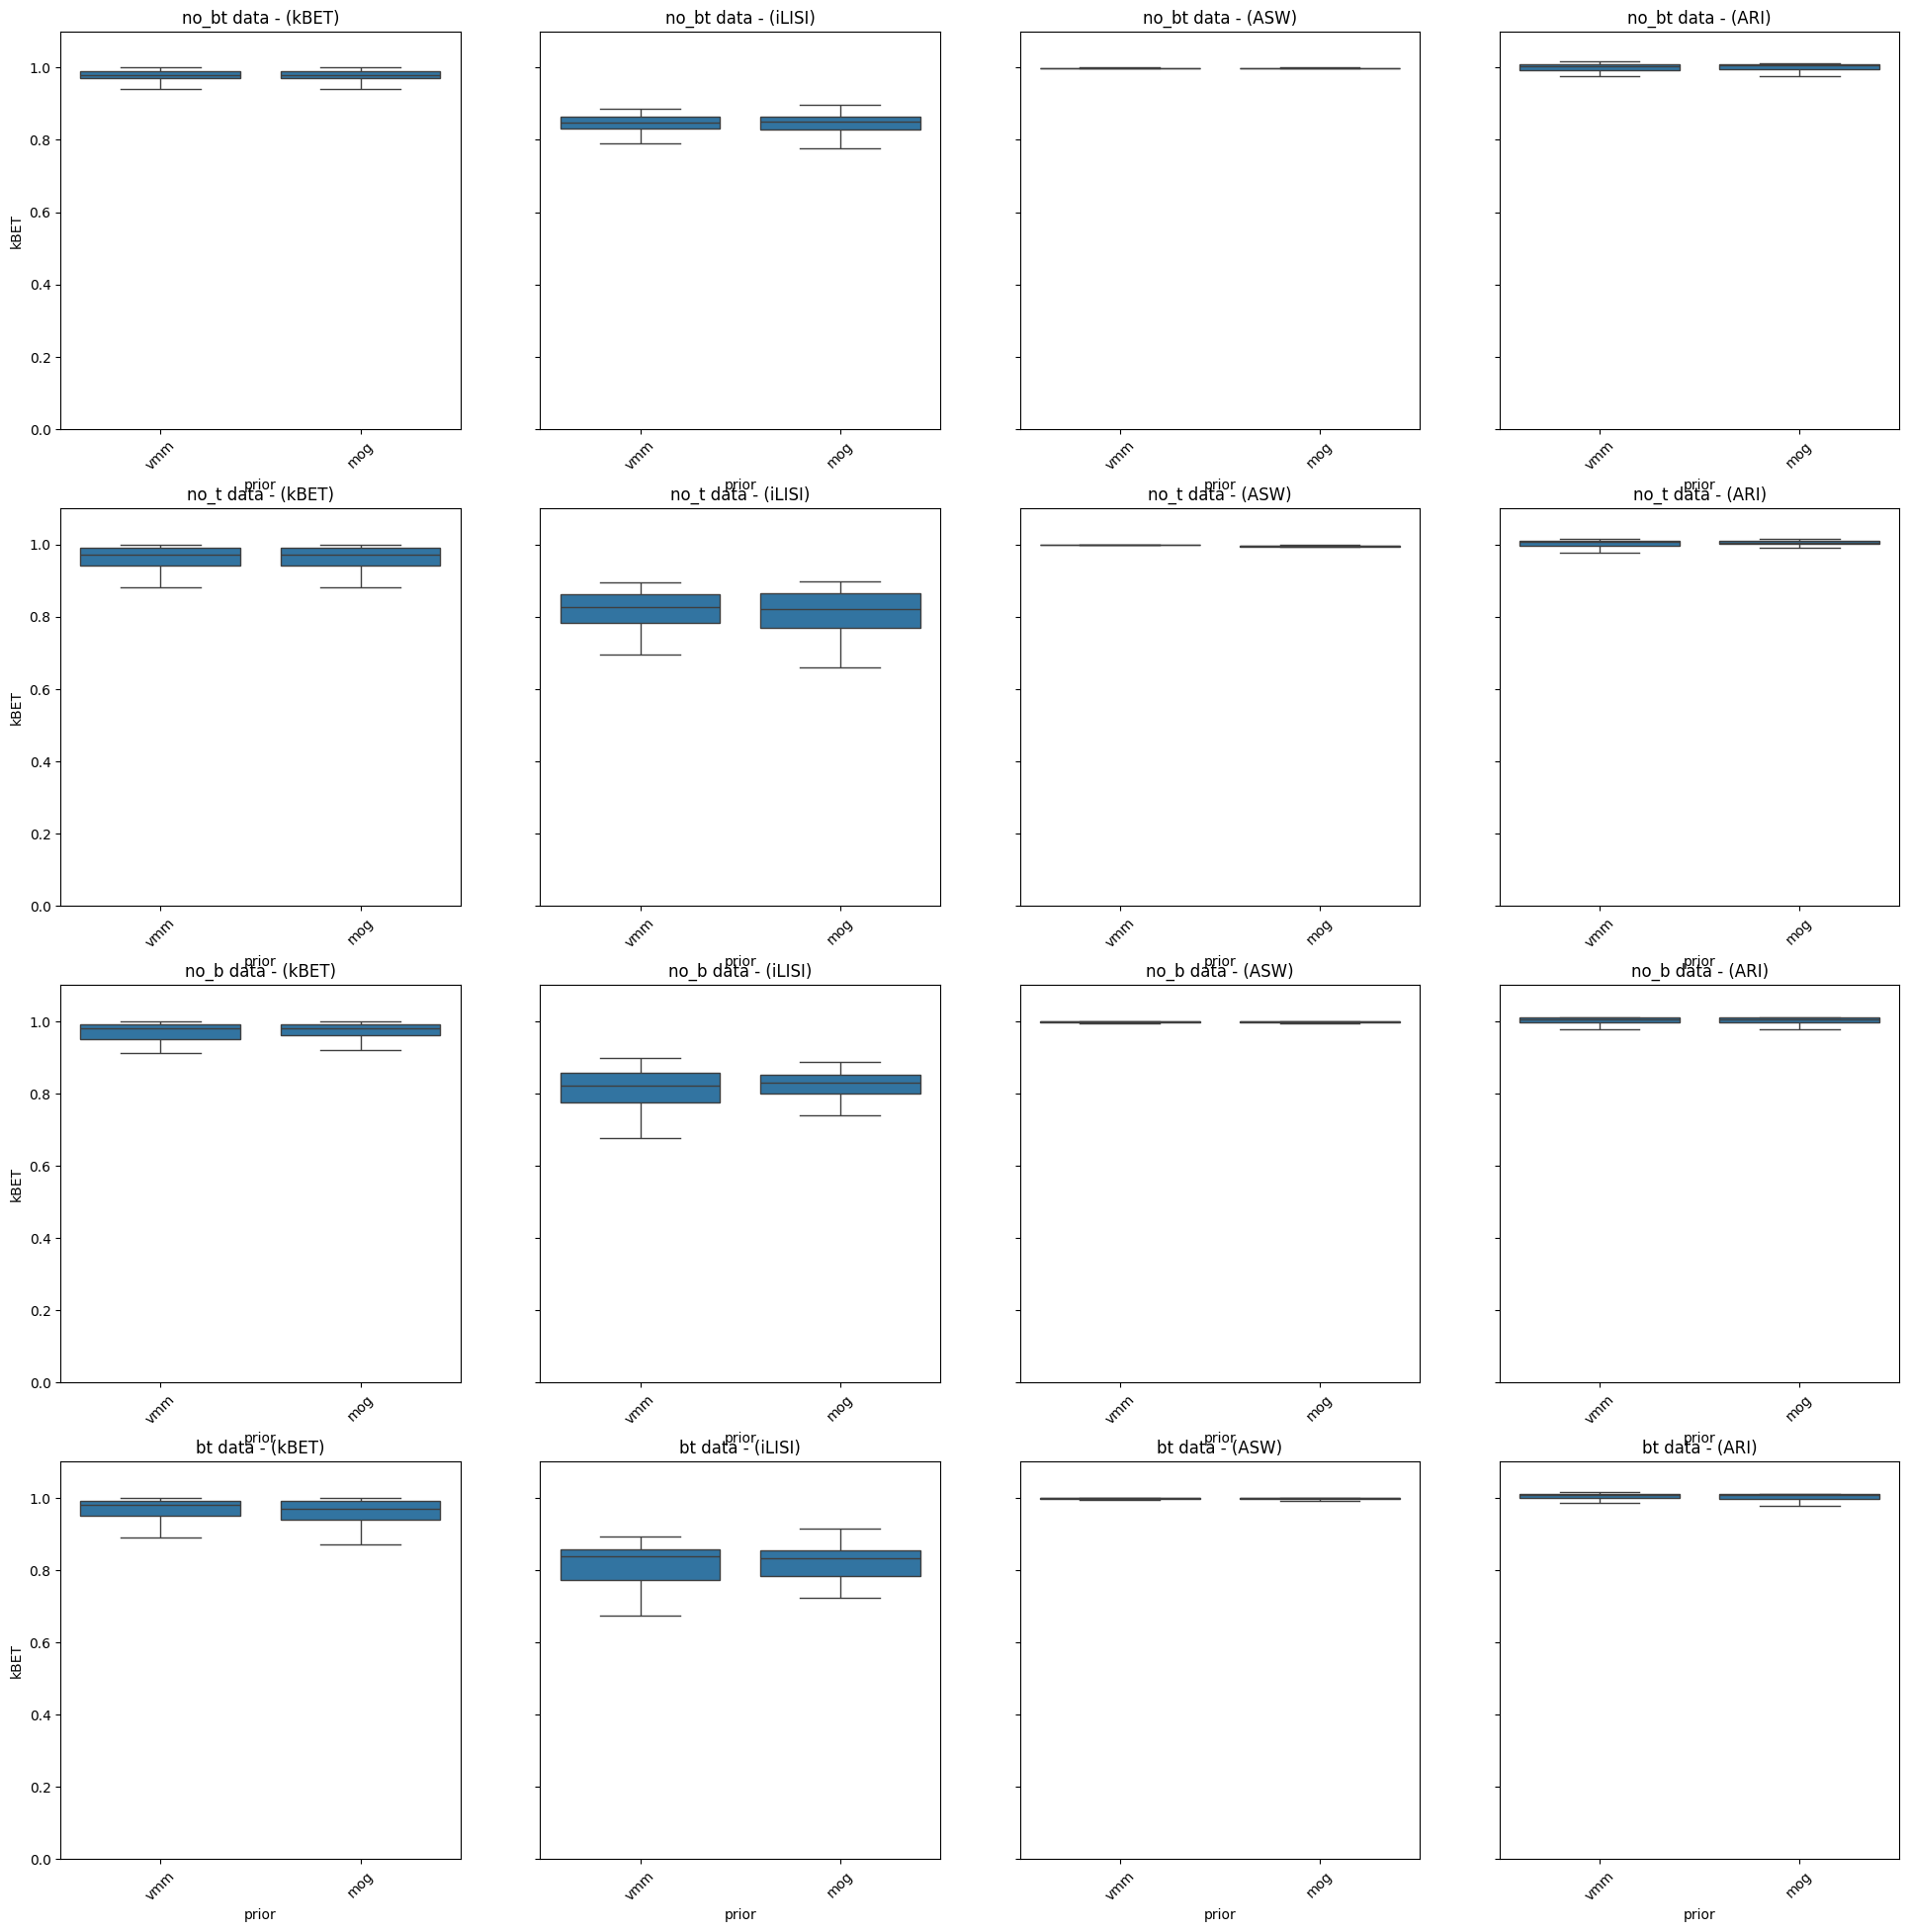

In [65]:
fig, axes = plt.subplots(4, 4, figsize=(24, 24), sharey=True)

# Data frame to save values
abaco_kbet_results = pd.DataFrame()
abaco_ilisi_results = pd.DataFrame()
abaco_asw_results = pd.DataFrame()
abaco_ari_results = pd.DataFrame()

for i, dataset in enumerate(datasets):
    kbet_results = []
    ilisi_results = []
    asw_results = []
    ari_results = []

    for j, prior in enumerate(priors):
        abaco_runs = multi_runs[(multi_runs["dataset"] == dataset) & (multi_runs["prior"] == prior)]
        
        for k, abaco_run in enumerate(abaco_runs["run"]):

            recon_data = DataTransform(abaco_run, factors = [sample_label[i], batch_label[i], bio_label[i]], count = True)

            # Compute kBET
            abaco_kbet = kBET(data = recon_data, batch_label = batch_label[i])
            # Compute iLISI
            abaco_ilisi = iLISI_norm(data = recon_data, batch_label = batch_label[i])
            # Compute ASW
            abaco_asw = ASW(data = recon_data, interest_label = batch_label[i])
            abaco_asw = 1 - abs(abaco_asw)
            # Compute ARI
            abaco_ari = ARI_GMM(data = recon_data, interest_label=batch_label[i])
            abaco_ari = 1 - abaco_ari

            # Save value
            kbet_results.append({
                "iter": k,
                "prior": prior,
                "kBET": abaco_kbet,
                "dataset": dataset
            })
            ilisi_results.append({
                "iter": k,
                "prior": prior,
                "iLISI": abaco_ilisi,
                "dataset": dataset
            })
            asw_results.append({
                "iter": k,
                "prior": prior,
                "ASW": abaco_asw,
                "dataset": dataset
            })
            ari_results.append({
                "iter": k,
                "prior": prior,
                "ARI": abaco_ari,
                "dataset": dataset
            })
    
    sns.boxplot(
    data=pd.DataFrame(kbet_results),
    x='prior',
    y='kBET',
    ax=axes[i][0],
    showfliers=False,
    )
    axes[i][0].set_title(f'{dataset} data - (kBET)')
    axes[i][0].tick_params(axis='x', rotation=45)
    axes[i][0].set_ylim([0, 1.1])

    sns.boxplot(
    data=pd.DataFrame(ilisi_results),
    x='prior',
    y='iLISI',
    ax=axes[i][1],
    showfliers=False,
    )
    axes[i][1].set_title(f'{dataset} data - (iLISI)')
    axes[i][1].tick_params(axis='x', rotation=45)
    axes[i][0].set_ylim([0, 1.1])

    sns.boxplot(
    data=pd.DataFrame(asw_results),
    x='prior',
    y='ASW',
    ax=axes[i][2],
    showfliers=False
    )
    axes[i][2].set_title(f'{dataset} data - (ASW)')
    axes[i][2].tick_params(axis='x', rotation=45)
    axes[i][0].set_ylim([0, 1.1])

    sns.boxplot(
    data=pd.DataFrame(ari_results),
    x='prior',
    y='ARI',
    ax=axes[i][3],
    showfliers=False
    )
    axes[i][3].set_title(f'{dataset} data - (ARI)')
    axes[i][3].tick_params(axis='x', rotation=45)
    axes[i][0].set_ylim([0, 1.1])

    abaco_kbet_results = pd.concat([abaco_kbet_results, pd.DataFrame(kbet_results)], axis=0)
    abaco_ilisi_results = pd.concat([abaco_ilisi_results, pd.DataFrame(ilisi_results)], axis=0)
    abaco_asw_results = pd.concat([abaco_asw_results, pd.DataFrame(asw_results)], axis=0)
    abaco_ari_results = pd.concat([abaco_ari_results, pd.DataFrame(ari_results)], axis=0)

### PERMANOVA 

In [66]:
def permanova_ait(df, sample_label, group_label):
    samples = df[sample_label].values
    groups = df[group_label].values
    clr_data = df.select_dtypes(include = "number").values

    aitch = pdist(clr_data, metric = "euclidean")
    dist_mat = squareform(aitch)
    dm = DistanceMatrix(dist_mat, ids=samples)

    res_ait = permanova(distance_matrix=dm, grouping=groups)

    res_ait["R2"] = (
        res_ait["test statistic"]
        * (len(groups.unique()) - 1)
        / (
            res_ait["test statistic"] * (len(groups.unique()) - 1)
            + (len(samples) - len(groups.unique()))
        )
    )
    return res_ait

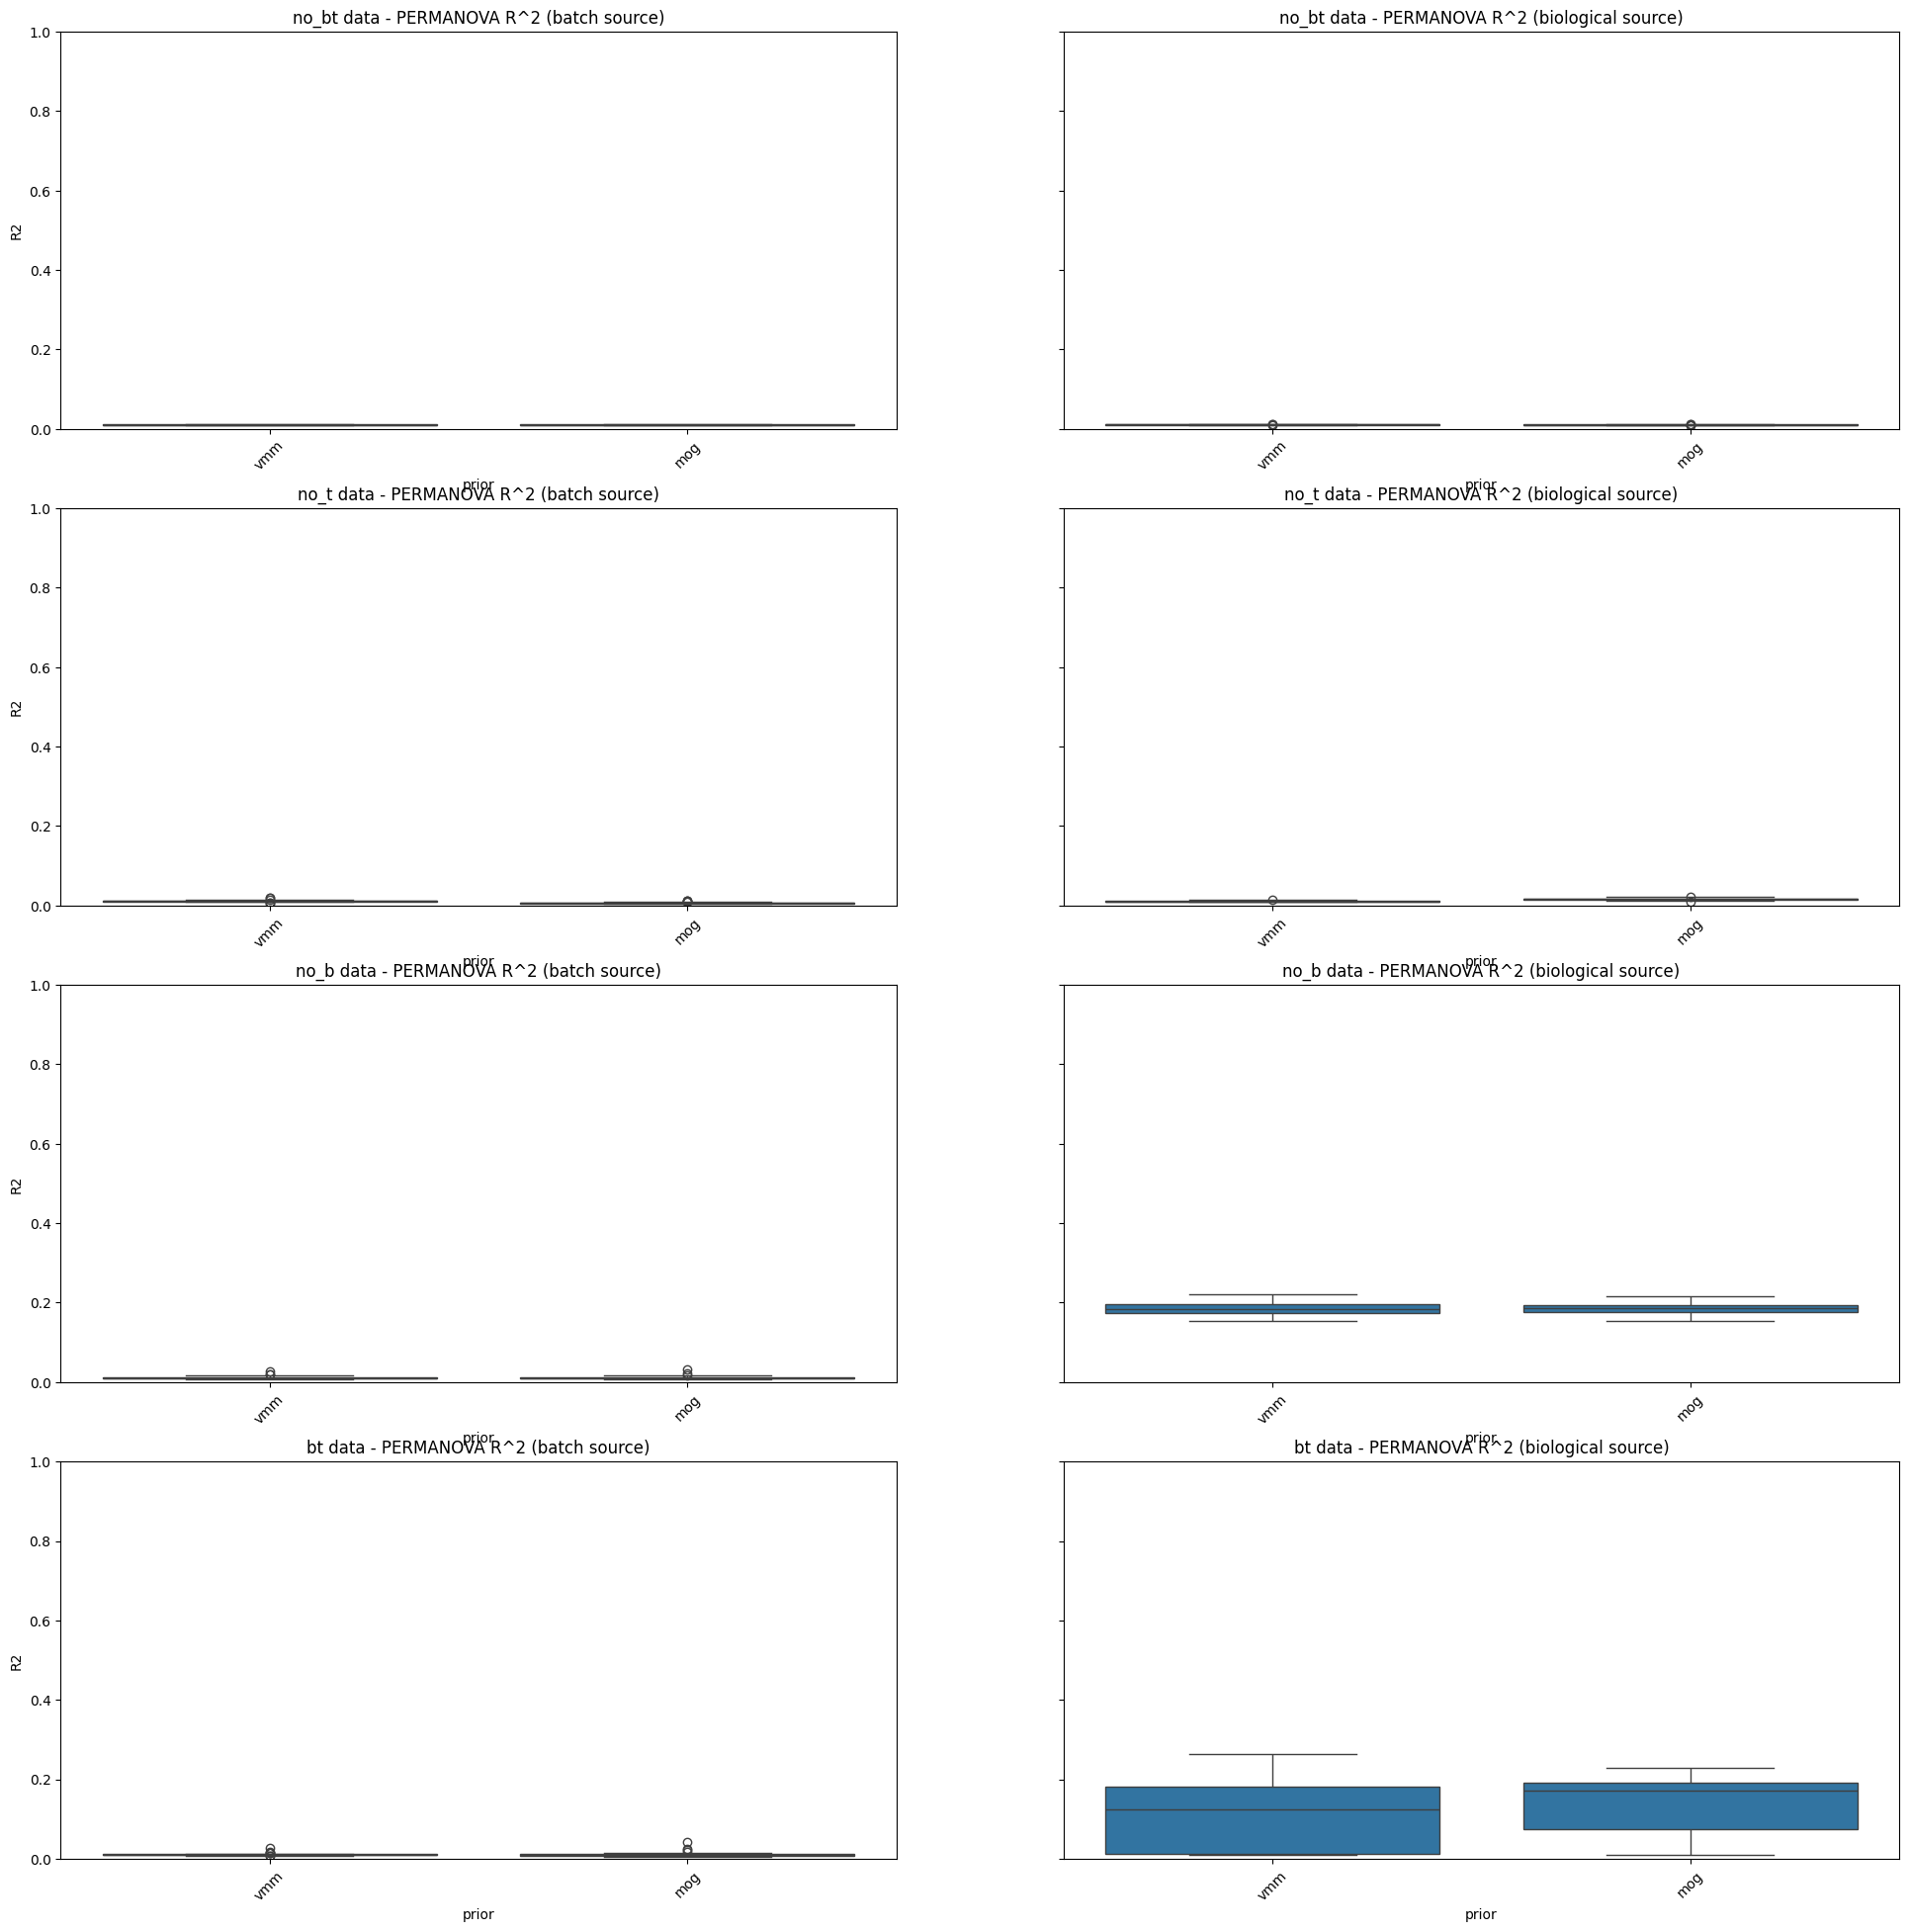

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(24, 24), sharey=True)

for i, dataset in enumerate(datasets):
    batch_permas = []
    bio_permas = []

    for j, prior in enumerate(priors):

        abaco_runs = multi_runs[(multi_runs["dataset"] == dataset) & (multi_runs["prior"] == prior)]
        
        kw_results_abaco = pd.DataFrame()

        for k, abaco_run in enumerate(abaco_runs["run"]):

            recon_data = DataTransform(abaco_run, factors = [sample_label[i], batch_label[i], bio_label[i]], count = True)

            batch_perma = permanova_ait(recon_data, sample_label[i], batch_label[i])["R2"]
            bio_perma = permanova_ait(recon_data, sample_label[i], bio_label[i])["R2"]

            batch_permas.append({"iter":k, "prior": prior, "R2": batch_perma})
            bio_permas.append({"iter":k, "prior": prior, "R2": bio_perma})
    
    sns.boxplot(
    data=pd.DataFrame(batch_permas),
    x='prior',
    y='R2',
    ax=axes[i][0]
    )
    axes[i][0].set_title(f'{dataset} data - PERMANOVA R^2 (batch source)')
    axes[i][0].tick_params(axis='x', rotation=45)

    sns.boxplot(
    data=pd.DataFrame(bio_permas),
    x='prior',
    y='R2',
    ax=axes[i][1]
    )
    axes[i][1].set_title(f'{dataset} data - PERMANOVA R^2 (biological source)')
    axes[i][1].tick_params(axis='x', rotation=45)
    
    axes[i][0].set_ylim(0, 1)
    axes[i][1].set_ylim(0, 1)